<div style="position: relative; width: 100%; max-width: 100%;">

  <img src="portada.jpg" style="width: 100%; max-height: 275px; object-fit: cover; display: block;">

 
</div>

## 📚 __Importación de librerias__

In [1]:
import plotly.express as px 
import numpy as np
import pandas as pd
import statistics as stat
import scipy.stats
from scipy.stats import pearsonr
import os
import mysql.connector
from dotenv import load_dotenv
from mysql.connector import Error
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import time
import seaborn as sns
import matplotlib.pyplot as plt

## 🛜 __Conexión Base de Datos SQL__

In [2]:
# Función que permite conectar Phyton con la Base de Datos de SQL- Las credenciales de MYSQL se encuentran protegidas en archivo .env

def abrir_conexion():
    load_dotenv()  # Carga variables desde el archivo .env

    host = os.getenv("DB_HOST")
    user = os.getenv("DB_USER")
    password = os.getenv("DB_PASSWORD")
    database = os.getenv("DB_NAME")

    try:
        conexion = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        cursor = conexion.cursor()
        print("Conexión abierta")
        return conexion, cursor
    except Error as err:
        print("Error al conectar:", err)
        return None, None

# Llamada a la función
conexion, cursor = abrir_conexion()

Conexión abierta


## 👀 __Exploración de Datos__  


### ✅ __Tabla COUNTRY__

__Utilizamos una consulta SQL para recuperar todos los datos de la tabla `country`, obtenemos automáticamente los nombres de las columnas con `cursor.description`, y almacenamos el resultado en un `DataFrame` de pandas.__

In [3]:
cursor.execute("""
SELECT *
FROM country
""")

In [4]:
columnas = [col[0] for col in cursor.description]

In [5]:
resultados = cursor.fetchall()
dfcountry = pd.DataFrame(resultados, columns=columnas) #Guardo el resultado de la consulta en un DF 

In [6]:
dfcountry.head(10)

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
0,ABW,Aruba,North America,Caribbean,193.00,NaN,103000,78.4,828.00,793.00,Aruba,Nonmetropolitan Territory of The Netherlands,Beatrix,129.0,AW,None
1,AFG,Afghanistan,Asia,Southern and Central Asia,652090.00,1919.0,22720000,45.9,5976.00,None,Afganistan/Afqanestan,Islamic Emirate,Mohammad Omar,1.0,AF,None
2,AGO,Angola,Africa,Central Africa,1246700.00,1975.0,12878000,38.3,6648.00,7984.00,Angola,Republic,José Eduardo dos Santos,56.0,AO,None
3,AIA,Anguilla,North America,Caribbean,96.00,NaN,8000,76.1,63.20,None,Anguilla,Dependent Territory of the UK,Elisabeth II,62.0,AI,None
4,ALB,Albania,Europe,Southern Europe,28748.00,1912.0,3401200,71.6,3205.00,2500.00,Shqipëria,Republic,Rexhep Mejdani,34.0,AL,None
5,AND,Andorra,Europe,Southern Europe,468.00,1278.0,78000,83.5,1630.00,None,Andorra,Parliamentary Coprincipality,,55.0,AD,None
6,ANT,Netherlands Antilles,North America,Caribbean,800.00,NaN,217000,74.7,1941.00,None,Nederlandse Antillen,Nonmetropolitan Territory of The Netherlands,Beatrix,33.0,AN,None
7,ARE,United Arab Emirates,Asia,Middle East,83600.00,1971.0,2441000,74.1,37966.00,36846.00,Al-Imarat al-´Arabiya al-Muttahida,Emirate Federation,Zayid bin Sultan al-Nahayan,65.0,AE,None
8,ARG,Argentina,South America,South America,2780400.00,1816.0,37032000,75.1,340238.00,323310.00,Argentina,Federal Republic,Fernando de la Rúa,69.0,AR,None
9,ARM,Armenia,Asia,Middle East,29800.00,1991.0,3520000,66.4,1813.00,1627.00,Hajastan,Republic,Robert Kotšarjan,126.0,AM,None


In [9]:
dfcountry.info() # Tipo de datos y nulos de cada columna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Code            239 non-null    object 
 1   Name            239 non-null    object 
 2   Continent       239 non-null    object 
 3   Region          239 non-null    object 
 4   SurfaceArea     239 non-null    object 
 5   IndepYear       192 non-null    float64
 6   Population      239 non-null    int64  
 7   LifeExpectancy  222 non-null    object 
 8   GNP             239 non-null    object 
 9   GNPOld          178 non-null    object 
 10  LocalName       239 non-null    object 
 11  GovernmentForm  239 non-null    object 
 12  HeadOfState     238 non-null    object 
 13  Capital         232 non-null    float64
 14  Code2           239 non-null    object 
 15  NewGovernment   0 non-null      object 
dtypes: float64(2), int64(1), object(13)
memory usage: 30.0+ KB


#### ‼️ Hay 17 paises que no tienen la esperanza de vida (valores nulos) y además ese valor está en tipo object.

* 1- Voy a cambiar el tipo de dato a numérico, para poder analizar las medidas estadísticas.
* 2- Voy a analizar nulos, ver si es conveniente no considerarlos en el analisis o rellenarlos

In [5]:
dfcountry['LifeExpectancy'] = pd.to_numeric(dfcountry['LifeExpectancy'], errors='coerce') # Cambio el tipo de dato a numérico

In [6]:
# Analizo el % de población de los paises donde no tenemos el dato de la esperanza de vida y es solo un 5% de la población mundial
dfcountry[dfcountry['LifeExpectancy'].isnull()]['Population'].sum()/dfcountry['Population'].sum() 

np.float64(4.992803248372081e-06)

In [7]:
dfcountry.info() # Comprobación del cambio de tipo de dato de Esperanza de Vida

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Code            239 non-null    object 
 1   Name            239 non-null    object 
 2   Continent       239 non-null    object 
 3   Region          239 non-null    object 
 4   SurfaceArea     239 non-null    object 
 5   IndepYear       192 non-null    float64
 6   Population      239 non-null    int64  
 7   LifeExpectancy  222 non-null    float64
 8   GNP             239 non-null    object 
 9   GNPOld          178 non-null    object 
 10  LocalName       239 non-null    object 
 11  GovernmentForm  239 non-null    object 
 12  HeadOfState     238 non-null    object 
 13  Capital         232 non-null    float64
 14  Code2           239 non-null    object 
 15  NewGovernment   0 non-null      object 
dtypes: float64(3), int64(1), object(12)
memory usage: 30.0+ KB


In [8]:
# Función para rellenar los valores vacíos de Esperanza de Vida con el promedio regional
dfcountry['LifeExpectancy'] = dfcountry.groupby('Continent')['LifeExpectancy'].transform(lambda x: x.fillna(x.mean())) 

In [9]:
 # Chequeo los nulos en la columna Esperanza de Vida para confirmar que el rellenado haya sido exitoso
dfcountry['LifeExpectancy'].isnull().sum()

np.int64(5)

#### ‼️ Los paises de Antarctica no se rellenaron, pero vemos que no hay registro de población en los mismos ( es cero) por lo que lo dejaremos asi, nulos para nuestro analisis

In [10]:
# Los paises de Antarctica no se rellenaron, pero vemos que no hay registro de población en los mismos ( es cero) por lo que lo dejaremos asi, nulos para nuestro analisis
dfcountry[dfcountry['Continent'] == 'Antarctica'] 

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
11,ATA,Antarctica,Antarctica,Antarctica,13120000.00,NaN,0,NaN,0.00,None,–,Co-administrated,,NaN,AQ,None
12,ATF,French Southern territories,Antarctica,Antarctica,7780.00,NaN,0,NaN,0.00,None,Terres australes françaises,Nonmetropolitan Territory of France,Jacques Chirac,NaN,TF,None
34,BVT,Bouvet Island,Antarctica,Antarctica,59.00,NaN,0,NaN,0.00,None,Bouvetøya,Dependent Territory of Norway,Harald V,NaN,BV,None
93,HMD,Heard Island and McDonald Islands,Antarctica,Antarctica,359.00,NaN,0,NaN,0.00,None,Heard and McDonald Islands,Territory of Australia,Elisabeth II,NaN,HM,None
187,SGS,South Georgia and the South Sandwich Islands,Antarctica,Antarctica,3903.00,NaN,0,NaN,0.00,None,South Georgia and the South Sandwich Islands,Dependent Territory of the UK,Elisabeth II,NaN,GS,None


#### ✳️ Hemos solucionado el problema de los nulos en LifeExpectancy

#### ‼️ El campo GNP, que sería el PNB no tiene nulos pero está en tipo de dato objetc. Lo cambiaremos a numérico para poder analizar esta variable

In [21]:
dfcountry['GNP'] = pd.to_numeric(dfcountry['GNP'], errors='coerce') # Cambio el tipo de dato a numérico

In [22]:
dfcountry.describe()

,IndepYear,Population,LifeExpectancy,GNP,Capital
count,192.000000,2.390000e+02,234.000000,2.390000e+02,232.000000
mean,1847.260417,2.543410e+07,66.630058,1.228239e+05,2071.306034
std,420.831370,1.093398e+08,11.302962,6.379976e+05,1184.095609
min,-1523.000000,0.000000e+00,37.200000,0.000000e+00,1.000000
25%,1906.750000,2.380000e+05,60.825000,6.400000e+02,915.750000
50%,1960.000000,3.869000e+06,69.807500,4.787000e+03,2449.500000
75%,1974.000000,1.493550e+07,75.200000,2.994450e+04,3065.250000
max,1994.000000,1.277558e+09,83.500000,8.510700e+06,4074.000000


#### ✳️ Análisis valores máximos y mínimos ( Life Expectancy, IndepYear, Population, GNP)

In [30]:
dfcountry[dfcountry['LifeExpectancy'] == dfcountry['LifeExpectancy'].max()] # LifeExpectancy Max- Media: 66.63

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
5,AND,Andorra,Europe,Southern Europe,468.00,1278.0,78000,83.5,1630.00,None,Andorra,Parliamentary Coprincipality,,55.0,AD,None,20897.0


In [31]:
dfcountry[dfcountry['LifeExpectancy'] == dfcountry['LifeExpectancy'].min()]# LifeExpectancy Min- Media: 66.63

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
237,ZMB,Zambia,Africa,Eastern Africa,752618.00,1964.0,9169000,37.2,3377.00,3922.00,Zambia,Republic,Frederick Chiluba,3162.0,ZM,None,368.0


In [34]:
dfcountry.sort_values(by="LifeExpectancy", ascending=False).head(20)  #Paises con mayor esperanza de vida

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
5,AND,Andorra,Europe,Southern Europe,468.00,1278.0,78000,83.5,1630.00,None,Andorra,Parliamentary Coprincipality,,55.0,AD,None,20897.0
129,MAC,Macao,Asia,Eastern Asia,18.00,NaN,473000,81.6,5749.00,5940.00,Macau/Aomen,Special Administrative Region of China,Jiang Zemin,2454.0,MO,None,12154.0
193,SMR,San Marino,Europe,Southern Europe,61.00,885.0,27000,81.1,510.00,None,San Marino,Republic,None,3171.0,SM,None,18889.0
109,JPN,Japan,Asia,Eastern Asia,377829.00,-660.0,126714000,80.7,3787042.00,4192638.00,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP,None,29887.0
186,SGP,Singapore,Asia,Southeast Asia,618.00,1965.0,3567000,80.1,86503.00,96318.00,Singapore/Singapura/Xinjiapo/Singapur,Republic,Sellapan Rama Nathan,3208.0,SG,None,24251.0
14,AUS,Australia,Oceania,Australia and New Zealand,7741220.00,1901.0,18886000,79.8,351182.00,392911.00,Australia,"Constitutional Monarchy, Federation",Elisabeth II,135.0,AU,None,18595.0
200,SWE,Sweden,Europe,Nordic Countries,449964.00,836.0,8861400,79.6,226492.00,227757.00,Sverige,Constitutional Monarchy,Carl XVI Gustaf,3048.0,SE,None,25559.0
39,CHE,Switzerland,Europe,Western Europe,41284.00,1499.0,7160400,79.6,264478.00,256092.00,Schweiz/Suisse/Svizzera/Svizra,Federation,Adolf Ogi,3248.0,CH,None,36936.0
92,HKG,Hong Kong,Asia,Eastern Asia,1075.00,NaN,6782000,79.5,166448.00,173610.00,Xianggang/Hong Kong,Special Administrative Region of China,Jiang Zemin,937.0,HK,None,24543.0
37,CAN,Canada,North America,North America,9970610.00,1867.0,31147000,79.4,598862.00,625626.00,Canada,"Constitutional Monarchy, Federation",Elisabeth II,1822.0,CA,None,19227.0


In [6]:
dfcountry.sort_values(by="LifeExpectancy", ascending=True).head(20)  #Paises con menor esperanza de vida

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
237,ZMB,Zambia,Africa,Eastern Africa,752618.00,1964.0,9169000,37.2,3377.00,3922.00,Zambia,Republic,Frederick Chiluba,3162.0,ZM,None
143,MOZ,Mozambique,Africa,Eastern Africa,801590.00,1975.0,19680000,37.5,2891.00,2711.00,Moçambique,Republic,Joaquím A. Chissano,2698.0,MZ,None
148,MWI,Malawi,Africa,Eastern Africa,118484.00,1964.0,10925000,37.6,1687.00,2527.00,Malawi,Republic,Bakili Muluzi,2462.0,MW,None
238,ZWE,Zimbabwe,Africa,Eastern Africa,390757.00,1980.0,11669000,37.8,5951.00,8670.00,Zimbabwe,Republic,Robert G. Mugabe,4068.0,ZW,None
2,AGO,Angola,Africa,Central Africa,1246700.00,1975.0,12878000,38.3,6648.00,7984.00,Angola,Republic,José Eduardo dos Santos,56.0,AO,None
35,BWA,Botswana,Africa,Southern Africa,581730.00,1966.0,1622000,39.3,4834.00,4935.00,Botswana,Republic,Festus G. Mogae,204.0,BW,None
182,RWA,Rwanda,Africa,Eastern Africa,26338.00,1962.0,7733000,39.3,2036.00,1863.00,Rwanda/Urwanda,Republic,Paul Kagame,3047.0,RW,None
201,SWZ,Swaziland,Africa,Southern Africa,17364.00,1968.0,1008000,40.4,1206.00,1312.00,kaNgwane,Monarchy,Mswati III,3244.0,SZ,None
153,NER,Niger,Africa,Western Africa,1267000.00,1960.0,10730000,41.3,1706.00,1580.00,Niger,Republic,Mamadou Tandja,2738.0,NE,None
151,NAM,Namibia,Africa,Southern Africa,824292.00,1990.0,1726000,42.5,3101.00,3384.00,Namibia,Republic,Sam Nujoma,2726.0,NA,None


In [11]:
dfcountry[dfcountry['IndepYear'] == dfcountry['IndepYear'].max()] # IdepYear Max

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
169,PLW,Palau,Oceania,Micronesia,459.00,1994.0,19000,68.6,105.00,None,Belau/Palau,Republic,Kuniwo Nakamura,2881.0,PW,None


In [26]:
dfcountry[dfcountry['IndepYear'] == dfcountry['IndepYear'].min()]  # IdepYear Min

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
41,CHN,China,Asia,Eastern Asia,9572900.00,-1523.0,1277558000,71.4,982268.0,917719.00,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN,None


In [44]:
dfcountry[dfcountry['IndepYear'] < 1906].sort_values(by='IndepYear').head(30) # IdepYear paises que se independizaron antes 1906

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
41,CHN,China,Asia,Eastern Asia,9572900.00,-1523.0,1277558000,71.4,982268.00,917719.00,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN,None,769.0
68,ETH,Ethiopia,Africa,Eastern Africa,1104300.00,-1000.0,62565000,45.2,6353.00,6180.00,YeItyop´iya,Republic,Negasso Gidada,756.0,ET,None,102.0
109,JPN,Japan,Asia,Eastern Asia,377829.00,-660.0,126714000,80.7,3787042.00,4192638.00,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP,None,29887.0
59,DNK,Denmark,Europe,Nordic Countries,43094.00,800.0,5330000,76.5,174099.00,169264.00,Danmark,Constitutional Monarchy,Margrethe II,3315.0,DK,None,32664.0
200,SWE,Sweden,Europe,Nordic Countries,449964.00,836.0,8861400,79.6,226492.00,227757.00,Sverige,Constitutional Monarchy,Carl XVI Gustaf,3048.0,SE,None,25559.0
72,FRA,France,Europe,Western Europe,551500.00,843.0,59225700,78.8,1424285.00,1392448.00,France,Republic,Jacques Chirac,2974.0,FR,None,24048.0
193,SMR,San Marino,Europe,Southern Europe,61.00,885.0,27000,81.1,510.00,None,San Marino,Republic,None,3171.0,SM,None,18889.0
76,GBR,United Kingdom,Europe,British Islands,242900.00,1066.0,59623400,77.7,1378330.00,1296830.00,United Kingdom,Constitutional Monarchy,Elisabeth II,456.0,GB,None,23117.0
174,PRT,Portugal,Europe,Southern Europe,91982.00,1143.0,9997600,75.8,105954.00,102133.00,Portugal,Republic,Jorge Sampãio,2914.0,PT,None,10598.0
5,AND,Andorra,Europe,Southern Europe,468.00,1278.0,78000,83.5,1630.00,None,Andorra,Parliamentary Coprincipality,,55.0,AD,None,20897.0


In [46]:
dfcountry[dfcountry['IndepYear'] > 1974].sort_values(by='IndepYear').head(30) # IdepYear paises que se independizaron después de 1974

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
2,AGO,Angola,Africa,Central Africa,1246700.00,1975.0,12878000,38.3,6648.00,7984.00,Angola,Republic,José Eduardo dos Santos,56.0,AO,None,516.0
48,COM,Comoros,Africa,Eastern Africa,1862.00,1975.0,578000,60.0,4401.00,4361.00,Komori/Comores,Republic,Azali Assoumani,2295.0,KM,None,7614.0
49,CPV,Cape Verde,Africa,Western Africa,4033.00,1975.0,428000,68.9,435.00,420.00,Cabo Verde,Republic,António Mascarenhas Monteiro,1859.0,CV,None,1016.0
143,MOZ,Mozambique,Africa,Eastern Africa,801590.00,1975.0,19680000,37.5,2891.00,2711.00,Moçambique,Republic,Joaquím A. Chissano,2698.0,MZ,None,147.0
170,PNG,Papua New Guinea,Oceania,Melanesia,462840.00,1975.0,4807000,63.1,4988.00,6328.00,Papua New Guinea/Papua Niugini,Constitutional Monarchy,Elisabeth II,2884.0,PG,None,1038.0
197,SUR,Suriname,South America,South America,163265.00,1975.0,417000,71.4,870.00,706.00,Suriname,Republic,Ronald Venetiaan,3243.0,SR,None,2086.0
196,STP,Sao Tome and Principe,Africa,Central Africa,964.00,1975.0,147000,65.3,6.00,None,São Tomé e Príncipe,Republic,Miguel Trovoada,3172.0,ST,None,41.0
202,SYC,Seychelles,Africa,Eastern Africa,455.00,1976.0,77000,70.4,536.00,539.00,Sesel/Seychelles,Republic,France-Albert René,3206.0,SC,None,6961.0
57,DJI,Djibouti,Africa,Eastern Africa,23200.00,1977.0,638000,50.8,382.00,373.00,Djibouti/Jibuti,Republic,Ismail Omar Guelleh,585.0,DJ,None,599.0
190,SLB,Solomon Islands,Oceania,Melanesia,28896.00,1978.0,444000,71.3,182.00,220.00,Solomon Islands,Constitutional Monarchy,Elisabeth II,3161.0,SB,None,410.0


In [27]:
dfcountry[dfcountry['Population'] == dfcountry['Population'].max()]  # Population Max

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
41,CHN,China,Asia,Eastern Asia,9572900.00,-1523.0,1277558000,71.4,982268.0,917719.00,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN,None


In [162]:
dfcountry[dfcountry['Population'] == dfcountry['Population'].min()] # Population Min

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
11,ATA,Antarctica,Antarctica,Antarctica,13120000.00,NaN,0,NaN,0.00,None,–,Co-administrated,,NaN,AQ,None
12,ATF,French Southern territories,Antarctica,Antarctica,7780.00,NaN,0,NaN,0.00,None,Terres australes françaises,Nonmetropolitan Territory of France,Jacques Chirac,NaN,TF,None
34,BVT,Bouvet Island,Antarctica,Antarctica,59.00,NaN,0,NaN,0.00,None,Bouvetøya,Dependent Territory of Norway,Harald V,NaN,BV,None
93,HMD,Heard Island and McDonald Islands,Antarctica,Antarctica,359.00,NaN,0,NaN,0.00,None,Heard and McDonald Islands,Territory of Australia,Elisabeth II,NaN,HM,None
100,IOT,British Indian Ocean Territory,Africa,Eastern Africa,78.00,NaN,0,52.57193,0.00,None,British Indian Ocean Territory,Dependent Territory of the UK,Elisabeth II,NaN,IO,None
187,SGS,South Georgia and the South Sandwich Islands,Antarctica,Antarctica,3903.00,NaN,0,NaN,0.00,None,South Georgia and the South Sandwich Islands,Dependent Territory of the UK,Elisabeth II,NaN,GS,None
221,UMI,United States Minor Outlying Islands,Oceania,Micronesia/Caribbean,16.00,NaN,0,69.71500,0.00,None,United States Minor Outlying Islands,Dependent Territory of the US,George W. Bush,NaN,UM,None


In [28]:
# Para obtener los países con menor población pero distintos de 0, ordenamos el dataset en forma ascendente, y limitamos el resultado a 20.
dfcountry_sorted = dfcountry.sort_values(by='Population', ascending=True).head(20) 
dfcountry_sorted

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
12,ATF,French Southern territories,Antarctica,Antarctica,7780.00,NaN,0,NaN,0.0,None,Terres australes françaises,Nonmetropolitan Territory of France,Jacques Chirac,NaN,TF,None
11,ATA,Antarctica,Antarctica,Antarctica,13120000.00,NaN,0,NaN,0.0,None,–,Co-administrated,,NaN,AQ,None
34,BVT,Bouvet Island,Antarctica,Antarctica,59.00,NaN,0,NaN,0.0,None,Bouvetøya,Dependent Territory of Norway,Harald V,NaN,BV,None
93,HMD,Heard Island and McDonald Islands,Antarctica,Antarctica,359.00,NaN,0,NaN,0.0,None,Heard and McDonald Islands,Territory of Australia,Elisabeth II,NaN,HM,None
100,IOT,British Indian Ocean Territory,Africa,Eastern Africa,78.00,NaN,0,52.571930,0.0,None,British Indian Ocean Territory,Dependent Territory of the UK,Elisabeth II,NaN,IO,None
187,SGS,South Georgia and the South Sandwich Islands,Antarctica,Antarctica,3903.00,NaN,0,NaN,0.0,None,South Georgia and the South Sandwich Islands,Dependent Territory of the UK,Elisabeth II,NaN,GS,None
221,UMI,United States Minor Outlying Islands,Oceania,Micronesia/Caribbean,16.00,NaN,0,69.715000,0.0,None,United States Minor Outlying Islands,Dependent Territory of the US,George W. Bush,NaN,UM,None
166,PCN,Pitcairn,Oceania,Polynesia,49.00,NaN,50,69.715000,0.0,None,Pitcairn,Dependent Territory of the UK,Elisabeth II,2912.0,PN,None
38,CCK,Cocos (Keeling) Islands,Oceania,Australia and New Zealand,14.00,NaN,600,69.715000,0.0,None,Cocos (Keeling) Islands,Territory of Australia,Elisabeth II,2317.0,CC,None
225,VAT,Holy See (Vatican City State),Europe,Southern Europe,0.40,1929.0,1000,75.147727,9.0,None,Santa Sede/Città del Vaticano,Independent Church State,Johannes Paavali II,3538.0,VA,None


In [50]:
dfcountry[dfcountry['Population'] > 14935500].sort_values(by='Population', ascending = False).head(10) # Paises con población mayor a 14935500, Q4

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
41,CHN,China,Asia,Eastern Asia,9572900.00,-1523.0,1277558000,71.4,982268.00,917719.00,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN,None,769.0
99,IND,India,Asia,Southern and Central Asia,3287263.00,1947.0,1013662000,62.5,447114.00,430572.00,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109.0,IN,None,441.0
223,USA,United States,North America,North America,9363520.00,1776.0,278357000,77.1,8510700.00,8110900.00,United States,Federal Republic,George W. Bush,3813.0,US,None,30575.0
98,IDN,Indonesia,Asia,Southeast Asia,1904569.00,1945.0,212107000,68.0,84982.00,215002.00,Indonesia,Republic,Abdurrahman Wahid,939.0,ID,None,401.0
30,BRA,Brazil,South America,South America,8547403.00,1822.0,170115000,62.9,776739.00,804108.00,Brasil,Federal Republic,Fernando Henrique Cardoso,211.0,BR,None,4566.0
164,PAK,Pakistan,Asia,Southern and Central Asia,796095.00,1947.0,156483000,61.1,61289.00,58549.00,Pakistan,Republic,Mohammad Rafiq Tarar,2831.0,PK,None,392.0
181,RUS,Russian Federation,Europe,Eastern Europe,17075400.00,1991.0,146934000,67.2,276608.00,442989.00,Rossija,Federal Republic,Vladimir Putin,3580.0,RU,None,1883.0
21,BGD,Bangladesh,Asia,Southern and Central Asia,143998.00,1971.0,129155000,60.2,32852.00,31966.00,Bangladesh,Republic,Shahabuddin Ahmad,150.0,BD,None,254.0
109,JPN,Japan,Asia,Eastern Asia,377829.00,-660.0,126714000,80.7,3787042.00,4192638.00,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP,None,29887.0
155,NGA,Nigeria,Africa,Western Africa,923768.00,1960.0,111506000,51.6,65707.00,58623.00,Nigeria,Federal Republic,Olusegun Obasanjo,2754.0,NG,None,589.0


In [29]:
dfcountry[dfcountry['GNP'] == dfcountry['GNP'].max()] #PNB Total Max

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
223,USA,United States,North America,North America,9363520.00,1776.0,278357000,77.1,8510700.0,8110900.00,United States,Federal Republic,George W. Bush,3813.0,US,None


In [30]:
dfcountry[dfcountry['GNP'] == dfcountry['GNP'].min()] #PNB Total Min

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
11,ATA,Antarctica,Antarctica,Antarctica,13120000.00,NaN,0,NaN,0.0,None,–,Co-administrated,,NaN,AQ,None
12,ATF,French Southern territories,Antarctica,Antarctica,7780.00,NaN,0,NaN,0.0,None,Terres australes françaises,Nonmetropolitan Territory of France,Jacques Chirac,NaN,TF,None
34,BVT,Bouvet Island,Antarctica,Antarctica,59.00,NaN,0,NaN,0.0,None,Bouvetøya,Dependent Territory of Norway,Harald V,NaN,BV,None
38,CCK,Cocos (Keeling) Islands,Oceania,Australia and New Zealand,14.00,NaN,600,69.715000,0.0,None,Cocos (Keeling) Islands,Territory of Australia,Elisabeth II,2317.0,CC,None
52,CXR,Christmas Island,Oceania,Australia and New Zealand,135.00,NaN,2500,69.715000,0.0,None,Christmas Island,Territory of Australia,Elisabeth II,1791.0,CX,None
71,FLK,Falkland Islands,South America,South America,12173.00,NaN,2000,70.946154,0.0,None,Falkland Islands,Dependent Territory of the UK,Elisabeth II,763.0,FK,None
73,FRO,Faroe Islands,Europe,Nordic Countries,1399.00,NaN,43000,78.400000,0.0,None,Føroyar,Part of Denmark,Margrethe II,901.0,FO,None
87,GRL,Greenland,North America,North America,2166090.00,NaN,56000,68.100000,0.0,None,Kalaallit Nunaat/Grønland,Part of Denmark,Margrethe II,917.0,GL,None
93,HMD,Heard Island and McDonald Islands,Antarctica,Antarctica,359.00,NaN,0,NaN,0.0,None,Heard and McDonald Islands,Territory of Australia,Elisabeth II,NaN,HM,None
100,IOT,British Indian Ocean Territory,Africa,Eastern Africa,78.00,NaN,0,52.571930,0.0,None,British Indian Ocean Territory,Dependent Territory of the UK,Elisabeth II,NaN,IO,None


In [31]:
(dfcountry['GNP'] == 0).sum() # Hay 24 paises que tienen PNB igual a cero

np.int64(24)

In [32]:
#Paises con menor PNB total, distintos de cero
dfcountry_sorted = dfcountry[dfcountry["GNP"] > 0].sort_values(by="GNP", ascending=True).head(20)
dfcountry_sorted 

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment
216,TUV,Tuvalu,Oceania,Polynesia,26.00,1978.0,12000,66.300000,6.0,None,Tuvalu,Constitutional Monarchy,Elisabeth II,3424.0,TV,None
196,STP,Sao Tome and Principe,Africa,Central Africa,964.00,1975.0,147000,65.300000,6.0,None,São Tomé e Príncipe,Republic,Miguel Trovoada,3172.0,ST,None
225,VAT,Holy See (Vatican City State),Europe,Southern Europe,0.40,1929.0,1000,75.147727,9.0,None,Santa Sede/Città del Vaticano,Independent Church State,Johannes Paavali II,3538.0,VA,None
114,KIR,Kiribati,Oceania,Micronesia,726.00,1979.0,83000,59.800000,40.7,None,Kiribati,Republic,Teburoro Tito,2256.0,KI,None
65,ESH,Western Sahara,Africa,Northern Africa,266000.00,NaN,293000,49.800000,60.0,None,As-Sahrawiya,Occupied by Marocco,Mohammed Abdel Aziz,2453.0,EH,None
3,AIA,Anguilla,North America,Caribbean,96.00,NaN,8000,76.100000,63.2,None,Anguilla,Dependent Territory of the UK,Elisabeth II,62.0,AI,None
204,TCA,Turks and Caicos Islands,North America,Caribbean,430.00,NaN,17000,73.300000,96.0,None,The Turks and Caicos Islands,Dependent Territory of the UK,Elisabeth II,3423.0,TC,None
136,MHL,Marshall Islands,Oceania,Micronesia,181.00,1990.0,64000,65.500000,97.0,None,Marshall Islands/Majol,Republic,Kessai Note,2507.0,MH,None
46,COK,Cook Islands,Oceania,Polynesia,236.00,NaN,20000,71.100000,100.0,None,The Cook Islands,Nonmetropolitan Territory of New Zealand,Elisabeth II,583.0,CK,None
169,PLW,Palau,Oceania,Micronesia,459.00,1994.0,19000,68.600000,105.0,None,Belau/Palau,Republic,Kuniwo Nakamura,2881.0,PW,None


#### ✳️ Calculamos una nueva columna: PNB/Cápita

In [150]:
dfcountry["GNP_per_capita"] = dfcountry.apply(
    lambda row: (row["GNP"] * 1_000_000 / row["Population"]) if pd.notnull(row["GNP"]) and pd.notnull(row["Population"]) and row["Population"] != 0 else None,
    axis=1
)
# Calculamos una nueva columna, con valores del PNB per capita

In [151]:
dfcountry["GNP_per_capita"] = pd.to_numeric(dfcountry["GNP_per_capita"].round(0), downcast="integer", errors="coerce")
dfcountry["GNP_per_capita"] = dfcountry["GNP_per_capita"].round(0) # Redondeamos valores 

In [152]:
dfcountry[dfcountry['GNP_per_capita'] == dfcountry['GNP_per_capita'].max()] #PNB/cápita  Max

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
127,LUX,Luxembourg,Europe,Western Europe,2586.00,1867.0,435700,77.1,16321.00,15519.00,Luxembourg/Lëtzebuerg,Constitutional Monarchy,Henri,2452.0,LU,None,37459.0


In [21]:
dfcountry[dfcountry['GNP_per_capita'] == dfcountry['GNP_per_capita'].min()] #PNB/cápita  Min

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
38,CCK,Cocos (Keeling) Islands,Oceania,Australia and New Zealand,14.00,NaN,600,69.715000,0.00,None,Cocos (Keeling) Islands,Territory of Australia,Elisabeth II,2317.0,CC,None,0.0
52,CXR,Christmas Island,Oceania,Australia and New Zealand,135.00,NaN,2500,69.715000,0.00,None,Christmas Island,Territory of Australia,Elisabeth II,1791.0,CX,None,0.0
71,FLK,Falkland Islands,South America,South America,12173.00,NaN,2000,70.946154,0.00,None,Falkland Islands,Dependent Territory of the UK,Elisabeth II,763.0,FK,None,0.0
73,FRO,Faroe Islands,Europe,Nordic Countries,1399.00,NaN,43000,78.400000,0.00,None,Føroyar,Part of Denmark,Margrethe II,901.0,FO,None,0.0
87,GRL,Greenland,North America,North America,2166090.00,NaN,56000,68.100000,0.00,None,Kalaallit Nunaat/Grønland,Part of Denmark,Margrethe II,917.0,GL,None,0.0
142,MNP,Northern Mariana Islands,Oceania,Micronesia,464.00,NaN,78000,75.500000,0.00,None,Northern Mariana Islands,Commonwealth of the US,George W. Bush,2913.0,MP,None,0.0
150,MYT,Mayotte,Africa,Eastern Africa,373.00,NaN,149000,59.500000,0.00,None,Mayotte,Territorial Collectivity of France,Jacques Chirac,2514.0,YT,None,0.0
154,NFK,Norfolk Island,Oceania,Australia and New Zealand,36.00,NaN,2000,69.715000,0.00,None,Norfolk Island,Territory of Australia,Elisabeth II,2806.0,NF,None,0.0
157,NIU,Niue,Oceania,Polynesia,260.00,NaN,2000,69.715000,0.00,None,Niue,Nonmetropolitan Territory of New Zealand,Elisabeth II,2805.0,NU,None,0.0
166,PCN,Pitcairn,Oceania,Polynesia,49.00,NaN,50,69.715000,0.00,None,Pitcairn,Dependent Territory of the UK,Elisabeth II,2912.0,PN,None,0.0


In [26]:
#Paises con menor PNB/cápita, distintos de cero
dfcountry_sorted = dfcountry[dfcountry["GNP_per_capita"] > 0].sort_values(by="GNP_per_capita", ascending=True).head(30)
dfcountry_sorted  

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
196,STP,Sao Tome and Principe,Africa,Central Africa,964.00,1975.0,147000,65.3,6.00,None,São Tomé e Príncipe,Republic,Miguel Trovoada,3172.0,ST,None,41.0
194,SOM,Somalia,Africa,Eastern Africa,637657.00,1960.0,10097000,46.2,935.00,None,Soomaaliya,Republic,Abdiqassim Salad Hassan,3214.0,SO,None,93.0
68,ETH,Ethiopia,Africa,Eastern Africa,1104300.00,-1000.0,62565000,45.2,6353.00,6180.00,YeItyop´iya,Republic,Negasso Gidada,756.0,ET,None,102.0
17,BDI,Burundi,Africa,Eastern Africa,27834.00,1962.0,6695000,46.2,903.00,982.00,Burundi/Uburundi,Republic,Pierre Buyoya,552.0,BI,None,135.0
44,COD,"Congo, The Democratic Republic of the",Africa,Central Africa,2344858.00,1960.0,51654000,48.8,6964.00,2474.00,République Démocratique du Congo,Republic,Joseph Kabila,2298.0,CD,None,135.0
143,MOZ,Mozambique,Africa,Eastern Africa,801590.00,1975.0,19680000,37.5,2891.00,2711.00,Moçambique,Republic,Joaquím A. Chissano,2698.0,MZ,None,147.0
148,MWI,Malawi,Africa,Eastern Africa,118484.00,1964.0,10925000,37.6,1687.00,2527.00,Malawi,Republic,Bakili Muluzi,2462.0,MW,None,154.0
191,SLE,Sierra Leone,Africa,Western Africa,71740.00,1961.0,4854000,45.3,746.00,858.00,Sierra Leone,Republic,Ahmed Tejan Kabbah,3207.0,SL,None,154.0
205,TCD,Chad,Africa,Central Africa,1284000.00,1960.0,7651000,50.5,1208.00,1102.00,Tchad/Tshad,Republic,Idriss Déby,3337.0,TD,None,158.0
153,NER,Niger,Africa,Western Africa,1267000.00,1960.0,10730000,41.3,1706.00,1580.00,Niger,Republic,Mamadou Tandja,2738.0,NE,None,159.0


In [25]:
dfcountry_sorted_desc = dfcountry[dfcountry["GNP_per_capita"] > 0].sort_values(by="GNP_per_capita", ascending=False).head(20)
dfcountry_sorted_desc  #Paises con mayor PNB/cápita.

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,NewGovernment,GNP_per_capita
127,LUX,Luxembourg,Europe,Western Europe,2586.00,1867.0,435700,77.1,16321.00,15519.00,Luxembourg/Lëtzebuerg,Constitutional Monarchy,Henri,2452.0,LU,None,37459.0
39,CHE,Switzerland,Europe,Western Europe,41284.00,1499.0,7160400,79.6,264478.00,256092.00,Schweiz/Suisse/Svizzera/Svizra,Federation,Adolf Ogi,3248.0,CH,None,36936.0
28,BMU,Bermuda,North America,North America,53.00,NaN,65000,76.9,2328.00,2190.00,Bermuda,Dependent Territory of the UK,Elisabeth II,191.0,BM,None,35815.0
32,BRN,Brunei,Asia,Southeast Asia,5765.00,1984.0,328000,73.6,11705.00,12460.00,Brunei Darussalam,Monarchy (Sultanate),Haji Hassan al-Bolkiah,538.0,BN,None,35686.0
123,LIE,Liechtenstein,Europe,Western Europe,160.00,1806.0,32300,78.8,1119.00,1084.00,Liechtenstein,Constitutional Monarchy,Hans-Adam II,2446.0,LI,None,34644.0
53,CYM,Cayman Islands,North America,Caribbean,264.00,NaN,38000,78.9,1263.00,1186.00,Cayman Islands,Dependent Territory of the UK,Elisabeth II,553.0,KY,None,33237.0
59,DNK,Denmark,Europe,Nordic Countries,43094.00,800.0,5330000,76.5,174099.00,169264.00,Danmark,Constitutional Monarchy,Margrethe II,3315.0,DK,None,32664.0
159,NOR,Norway,Europe,Nordic Countries,323877.00,1905.0,4478500,78.7,145895.00,153370.00,Norge,Constitutional Monarchy,Harald V,2807.0,NO,None,32577.0
223,USA,United States,North America,North America,9363520.00,1776.0,278357000,77.1,8510700.00,8110900.00,United States,Federal Republic,George W. Bush,3813.0,US,None,30575.0
109,JPN,Japan,Asia,Eastern Asia,377829.00,-660.0,126714000,80.7,3787042.00,4192638.00,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP,None,29887.0


### 🟰 __CONCLUSIONES__

### 🌱 __Esperanza de Vida:__

* 📆 La esperanza de vida promedio es de 66,6 años, lo que refleja un nivel medio de longevidad a nivel mundial según los datos disponibles.
- ⚠️ El país con menor esperanza de vida es Zambia (África) con tan solo 37,2 años, revelando condiciones de alta vulnerabilidad sanitaria, social y política.
- 🏔️ El valor más alto es de 83,5 años en Andorra, lo que puede considerarse un "techo" de longevidad actual asociado a un sistema de salud robusto y calidad de vida elevada.
- 📉 El 25% de los países tienen una esperanza de vida menor a 60,8 años. Estos países suelen tener un PBI per cápita muy bajo y desafíos estructurales en salud.
- 📈 El 25% superior supera los 75,2 años, representando a naciones con mayor desarrollo, como Andorra, Suiza, Noruega, Japón, etc.
- ⚖️ La mediana es de 69,8 años, bastante cercana al promedio, lo que indica una distribución relativamente simétrica sin grandes asimetrías.

### 🗽  __Año de Independencia :__

- 📆 Promedio de año de independencia: 1847, lo que refleja que muchos países obtuvieron su independencia en los siglos XIX y XX.
- 🗓️ Último país en independizarse: Palau (1994), ubicado en Oceanía.
- ⌛ Primer registro de independencia: China (1523 a.C.).
- 📉 Primer cuartil (Q1): El 25% de los países se independizó antes de 1906, principalmente potencias históricas como China, Japón, Francia, UK, y también paises de latinoamérica como Argentina, Chile, Venezuela y Perú.
- 📈 Tercer cuartil (Q3): El 25% más reciente obtuvo su independencia después de 1974, coincidiendo con procesos de descolonización en África, Asia y Oceanía.

### 👥  __Población :__
- 🌍 País con mayor población: China, con 1.277.558.000 habitantes.
- 📊 Media: 25.434.100 habitantes
- 📉 Desviación estándar: 109.339.800 → Alta dispersión (pocos países con muchísima población elevan la media).
- 🔸 25% de los países tienen menos de 238.000 habitantes → muchas poblaciones pequeñas o moderadas.
- 🔺 75% de los países tienen menos de 14.935.500 habitantes → pocas grandes potencias demográficas: China, India, Estados Unidos, Rusia, Brasil, Bangladesh.
- ❗ Datos nulos de población: 5 territorios en la Antártida, 1 país en África y 1 en Oceanía.
- 🧮 Países con menor población registrada: Pitcairn (Oceanía) con solo 50 habitantes y  Cocos Islands (Oceanía): 600 habitantes.


### 💰 __PNB TOTAL:__
* 🌎 El país con PBI más alto es Estados Unidos, con un total de 8.510.700 millones USD, lo que representa un PBI per cápita de 30.571 USD.
* 🏝️ Los países con PBI más bajo son: Tuvalu (Oceanía) y  São Tomé y Príncipe (África): 6 millones USD.


### 💰👥 __PNB_Per_Capita__:
#### 📊 El PNB per cápita se calculó como un indicador más representativo del nivel económico promedio por habitante.
- 🥇 País con mayor PNB per cápita: Luxemburgo → 37.459 USD/persona
- 🥈 País con menor PNB per cápita: São Tomé y Príncipe → 41 USD/persona
- 📌 Promedio global: ~6.090 USD
- ➗ Mediana: 1.741 USD → muy inferior al promedio → ➕ asimetría positiva (algunos países muy ricos elevan la media)
- 📉 Desviación estándar: 9.002,94 → 📢 Alta dispersión, refleja gran desigualdad económica
- 🔻 25% de los países tienen un PNB per cápita menor a 392 USD, concentrados en África y Asia
- 🔺 25% superior (PNB/cápita > 7.876 USD): economías desarrolladas como Luxemburgo, Suiza, Bermudas, Brunei, Liechtenstein.
### ↗️ __Relación PNB y esperanza de vida__
* 🔬 Al observar los países con menor PNB, se detecta una esperanza de vida muy baja. Para confirmar esta hipótesis, vamos a calcular las correlaciones.

In [153]:
df_clean = dfcountry[["GNP_per_capita", "LifeExpectancy"]].dropna()
correlation = df_clean["GNP_per_capita"].corr(df_clean["LifeExpectancy"])
print("Correlación de Pearson:", correlation)

Correlación de Pearson: 0.544250685125635


In [44]:
correlation_spearman = df_clean["GNP_per_capita"].corr(df_clean["LifeExpectancy"], method='spearman')
print("Correlación de Spearman:", correlation_spearman)

Correlación de Spearman: 0.6982258848389363


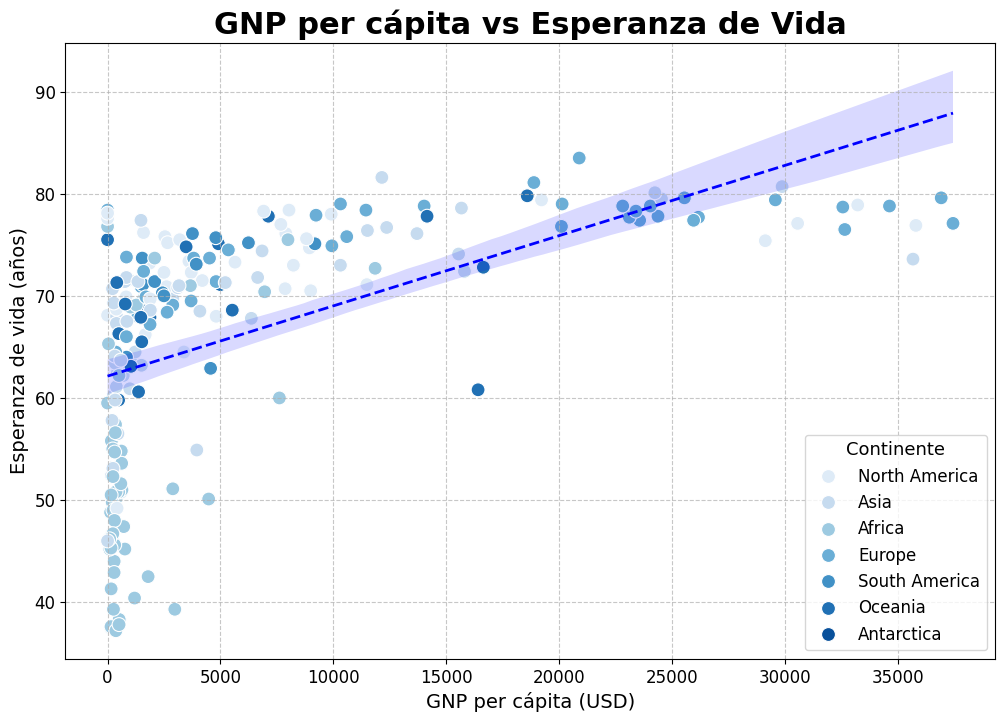

In [161]:
dfcountry['GNP_per_capita'] = pd.to_numeric(dfcountry['GNP_per_capita'], errors='coerce')
dfcountry['LifeExpectancy'] = pd.to_numeric(dfcountry['LifeExpectancy'], errors='coerce')
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=dfcountry,
    x='GNP_per_capita',
    y='LifeExpectancy',
    hue='Continent',
    palette='Blues',
    s=100  
)

sns.regplot(
    data=dfcountry,
    x='GNP_per_capita',
    y='LifeExpectancy',
    scatter=False,
    color='blue',
    line_kws={'linewidth':2, 'linestyle':'--'}
)

plt.title('GNP per cápita vs Esperanza de Vida', fontsize=22, weight='bold')
plt.xlabel('GNP per cápita (USD)', fontsize=14)
plt.ylabel('Esperanza de vida (años)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Continente', title_fontsize=13, fontsize=12)

plt.show()


### ↗️ __Relación entre PNB per cápita y expectativa de vida__ :
📊 El análisis de correlación entre el PNB per cápita (GNP_per_capita) y la expectativa de vida (LifeExpectancy) revela resultados significativos:
#### - 🧮 Correlación de Pearson:
- Valor ≈ 0.54
- 📌 Indica una relación lineal moderada y positiva: a medida que aumenta el PNB per cápita, tiende a aumentar también la expectativa de vida.
- 📉 No es una relación perfectamente lineal, pero sí consistente.
#### - 📈 Correlación de Spearman:
- Valor ≈ 0.74
- 🔁 Mide la relación monotónica (es decir, basada en rangos, no necesariamente lineal).
- 🧭 Este valor más alto sugiere una fuerte tendencia general: los países con mayor PNB per cápita tienden a tener mayor expectativa de vida, incluso si los incrementos no son proporcionales.
#### __✅ Conclusión: Aunque la relación no es estrictamente lineal, los datos reflejan claramente que mayor desarrollo económico se asocia con mayor longevidad. Esto puede deberse a mejores condiciones de salud, alimentación, educación y acceso a servicios básicos en países con mayor ingreso por habitante.__

### ✅ __Tabla CITY__

__Utilizamos una consulta SQL para recuperar todos los datos de la tabla `city`, obtenemos automáticamente los nombres de las columnas con `cursor.description`, y almacenamos el resultado en un `DataFrame` de pandas.__

In [10]:
cursor.execute("""
SELECT *
FROM city
""")

In [11]:
columnas = [col[0] for col in cursor.description]

In [12]:
resultados = cursor.fetchall()
dfcity = pd.DataFrame(resultados, columns=columnas) #Guardo el resultado de la consulta en un DF

In [13]:
dfcity.head()

,ID,Name,CountryCode,District,Population
0,1,Kabul,AFG,Kabol,1780000
1,2,Qandahar,AFG,Qandahar,237500
2,3,Herat,AFG,Herat,186800
3,4,Mazar-e-Sharif,AFG,Balkh,127800
4,5,Amsterdam,NLD,Noord-Holland,731200


In [48]:
dfcity.info() # Comprobamos tipo de dato y nulos de cada columna 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4079 entries, 0 to 4078
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           4079 non-null   int64 
 1   Name         4079 non-null   object
 2   CountryCode  4079 non-null   object
 3   District     4079 non-null   object
 4   Population   4079 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 159.5+ KB


In [49]:
dfcity.describe() # Indicadores estadisticos

,ID,Population
count,4079.000000,4.079000e+03
mean,2040.000000,3.504682e+05
std,1177.650203,7.237757e+05
min,1.000000,4.200000e+01
25%,1020.500000,1.147890e+05
50%,2040.000000,1.670510e+05
75%,3059.500000,3.106385e+05
max,4079.000000,1.050000e+07


#### ✳️ Todas las columnas están completas, no hay valores nulos

#### ✳️ Análisis valores máximos y mínimos - Population

In [67]:
# Uno los dos datasets (dfcity y dfcountry) para agregar el nombre del país y el continente
df_merged = dfcity.merge(
    dfcountry[['Code', 'Name', 'Continent']], 
    left_on='CountryCode',
    right_on='Code',
    how='inner'
)  
df_merged

,ID,Name_x,CountryCode,District,Population,Code,Name_y,Continent
0,1,Kabul,AFG,Kabol,1780000,AFG,Afghanistan,Asia
1,2,Qandahar,AFG,Qandahar,237500,AFG,Afghanistan,Asia
2,3,Herat,AFG,Herat,186800,AFG,Afghanistan,Asia
3,4,Mazar-e-Sharif,AFG,Balkh,127800,AFG,Afghanistan,Asia
4,5,Amsterdam,NLD,Noord-Holland,731200,NLD,Netherlands,Europe
...,...,...,...,...,...,...,...,...
4074,4075,Khan Yunis,PSE,Khan Yunis,123175,PSE,Palestine,Asia
4075,4076,Hebron,PSE,Hebron,119401,PSE,Palestine,Asia
4076,4077,Jabaliya,PSE,North Gaza,113901,PSE,Palestine,Asia
4077,4078,Nablus,PSE,Nablus,100231,PSE,Palestine,Asia


In [68]:
df_merged[df_merged['Population'] == df_merged['Population'].max()] #Ciudad más poblada

,ID,Name_x,CountryCode,District,Population,Code,Name_y,Continent
1023,1024,Mumbai (Bombay),IND,Maharashtra,10500000,IND,India,Asia


In [69]:
df_merged.sort_values(by='Population', ascending=False).head(20) #Ciudades más pobladas

,ID,Name_x,CountryCode,District,Population,Code,Name_y,Continent
1023,1024,Mumbai (Bombay),IND,Maharashtra,10500000,IND,India,Asia
2330,2331,Seoul,KOR,Seoul,9981619,KOR,South Korea,Asia
205,206,São Paulo,BRA,São Paulo,9968485,BRA,Brazil,South America
1889,1890,Shanghai,CHN,Shanghai,9696300,CHN,China,Asia
938,939,Jakarta,IDN,Jakarta Raya,9604900,IDN,Indonesia,Asia
2821,2822,Karachi,PAK,Sindh,9269265,PAK,Pakistan,Asia
3356,3357,Istanbul,TUR,Istanbul,8787958,TUR,Turkey,Asia
2514,2515,Ciudad de México,MEX,Distrito Federal,8591309,MEX,Mexico,North America
3579,3580,Moscow,RUS,Moscow (City),8389200,RUS,Russian Federation,Europe
3792,3793,New York,USA,New York,8008278,USA,United States,North America


In [70]:
df_merged[df_merged['Population'] == df_merged['Population'].min()] #Ciudad menos poblada

,ID,Name_x,CountryCode,District,Population,Code,Name_y,Continent
2911,2912,Adamstown,PCN,–,42,PCN,Pitcairn,Oceania


In [71]:
df_merged.sort_values(by='Population', ascending=True).head(20) # Ciudades menos pobladas

,ID,Name_x,CountryCode,District,Population,Code,Name_y,Continent
2911,2912,Adamstown,PCN,–,42,PCN,Pitcairn,Oceania
2316,2317,West Island,CCK,West Island,167,CCK,Cocos (Keeling) Islands,Oceania
3332,3333,Fakaofo,TKL,Fakaofo,300,TKL,Tokelau,Oceania
3537,3538,Città del Vaticano,VAT,–,455,VAT,Holy See (Vatican City State),Europe
2315,2316,Bantam,CCK,Home Island,503,CCK,Cocos (Keeling) Islands,Oceania
2727,2728,Yaren,NRU,–,559,NRU,Nauru,Oceania
61,62,The Valley,AIA,–,595,AIA,Anguilla,North America
2804,2805,Alofi,NIU,–,682,NIU,Niue,Oceania
1790,1791,Flying Fish Cove,CXR,–,700,CXR,Christmas Island,Oceania
2805,2806,Kingston,NFK,–,800,NFK,Norfolk Island,Oceania


### 🟰 __CONCLUSIONES__

### 🏙️ __Población de las ciudades:__
- 📌 Cantidad total de ciudades registradas: 4.079
- 👥 Promedio de población: 350.468 personas
- 🔀 Desviación estándar: 723.775 → refleja una gran dispersión, con ciudades muy pequeñas y otras extremadamente grandes.
- 🔽 25% de las ciudades tienen menos de 114.789 habitantes
- 🔼 75% de las ciudades tienen menos de 310.638 habitantes
- 🧮 Máximo: 10.500.000 personas — Mumbai (Bombay), India, Asia. Las siguientes ciudades más pobladas son Seúl, São Paulo, Shanghái, Yakarta (Indonesia) y Karachi (Pakistán), todas con más de 9.000.000 habitantes.
- 🧮 Mínimo: 42 personas — Adamstown, Islas Pitcairn, Oceanía. Otras ciudades con menor población incluyen Fakaofo (Tokelau), Ciudad del Vaticano, Bantam (Islas Cocos), Yaren (Nauru), The Valley (Anguila), Alofi (Niue), Flying Fish Cove (Isla de Navidad), Kingston (Isla Norfolk) y South Hill (Anguila), todas con menos de 1.000 habitantes.

### ✅ __Tabla COUNTRY_LANGUAJE__

__Utilizamos una consulta SQL para recuperar todos los datos de la tabla `country_language`, obtenemos automáticamente los nombres de las columnas con `cursor.description`, y almacenamos el resultado en un `DataFrame` de pandas.__

In [14]:
cursor.execute("""
SELECT *
FROM countrylanguage
""")

In [15]:
columnas = [col[0] for col in cursor.description]

In [16]:
resultados = cursor.fetchall()
dflanguage = pd.DataFrame(resultados, columns=columnas) #Guardo el resultado de la consulta en un DF

In [17]:
dflanguage.head()

,CountryCode,Language,IsOfficial,Percentage
0,ABW,Dutch,T,5.3
1,ABW,English,F,9.5
2,ABW,Papiamento,F,76.7
3,ABW,Spanish,F,7.4
4,AFG,Balochi,F,0.9


In [11]:
dflanguage.info() # Comprobación tipo de dato y nulos de las columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CountryCode  984 non-null    object
 1   Language     984 non-null    object
 2   IsOfficial   984 non-null    object
 3   Percentage   984 non-null    object
dtypes: object(4)
memory usage: 30.9+ KB


In [12]:
dflanguage.describe() 

,CountryCode,Language,IsOfficial,Percentage
count,984,984,984,984
unique,233,458,2,357
top,CAN,English,F,0.0
freq,12,60,746,65


#### ✳️ Todas las columnas están completas, no hay valores nulos

#### ‼️ No es válido sumar directamente los porcentajes de esta tabla para determinar cuál es el idioma más hablado en el mundo, ya que cada país tiene una población distinta y, por lo tanto, un peso demográfico diferente. 

* Para obtener una estimación más precisa, se realizó una unión entre la tabla de lenguajes y la de población, permitiendo ponderar los porcentajes según la población total de cada país.

In [17]:
# Unir con el DataFrame de países para tener la población de cada país
df_con_poblacion = dflanguage.merge(dfcountry[["Code", "Population"]], left_on="CountryCode", right_on="Code")

# Verificar si columnas Percentage y Population están en formato numérico
df_con_poblacion["Percentage"] = pd.to_numeric(df_con_poblacion["Percentage"], errors="coerce")
df_con_poblacion["Population"] = pd.to_numeric(df_con_poblacion["Population"], errors="coerce")

# Calcular hablantes estimados por idioma
df_con_poblacion["Hablantes"] = df_con_poblacion["Percentage"] / 100 * df_con_poblacion["Population"]

# Sumar hablantes por idioma
idiomas_hablantes = df_con_poblacion.groupby("Language")["Hablantes"].sum().sort_values(ascending=False)

# Mostrar el idioma más hablado
print("Idioma más hablado por hablantes estimados:", idiomas_hablantes.index[0])
print("Número estimado de hablantes:", round(idiomas_hablantes.iloc[0]))

Idioma más hablado por hablantes estimados: Chinese
Número estimado de hablantes: 1191843539


In [18]:
idiomas_hablantes = df_con_poblacion.groupby("Language")["Hablantes"].sum().sort_values(ascending=False)
idiomas_hablantes # Ordeno hablantes de mayor a menor

Language
Chinese        1.191844e+09
Hindi          4.056331e+08
Spanish        3.550295e+08
English        3.470779e+08
Arabic         2.338392e+08
                   ...     
Futuna         0.000000e+00
Saame          0.000000e+00
Sinaberberi    0.000000e+00
Soqutri        0.000000e+00
Tokelau        0.000000e+00
Name: Hablantes, Length: 458, dtype: float64

In [19]:
# Calculo el % de hablantes respecto al total de hablantes
total_hablantes = idiomas_hablantes.sum()
idiomas_hablantes_percent = (idiomas_hablantes / total_hablantes) * 100
idiomas_hablantes_percent.name = 'Porcentaje de hablantes'
idiomas_hablantes_percent

Language
Chinese        20.530749
Hindi           6.987453
Spanish         6.115753
English         5.978778
Arabic          4.028125
                 ...    
Futuna          0.000000
Saame           0.000000
Sinaberberi     0.000000
Soqutri         0.000000
Tokelau         0.000000
Name: Porcentaje de hablantes, Length: 458, dtype: float64

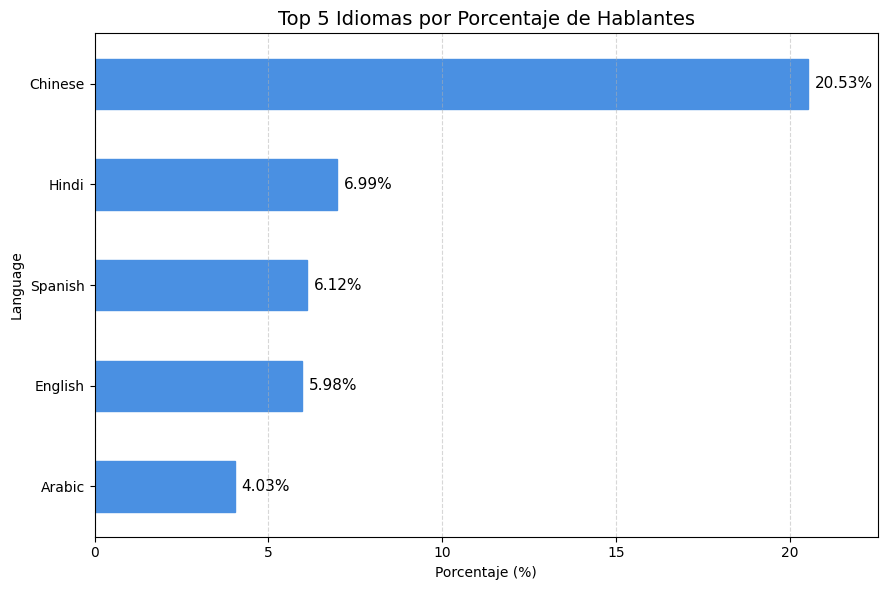

In [28]:
datos = idiomas_hablantes_percent.dropna().sort_values(ascending=False).head(5)

datos.plot(
    kind='barh',
    color='#4A90E2',
    edgecolor='#4A90E2',
    figsize=(9, 6)
)
plt.title('Top 5 Idiomas por Porcentaje de Hablantes', fontsize=14)
plt.xlabel('Porcentaje (%)')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, datos.max() + 2)

for i, v in enumerate(datos):
    plt.text(v + 0.2, i, f"{v:.2f}%", va='center', fontsize=11)

plt.tight_layout()
plt.show()

In [18]:
# Filtrar los idiomas con hablantes > 0 para evitar errores
idiomas_hablantes = idiomas_hablantes[idiomas_hablantes > 0]

# Ordenar de menor a mayor y seleccionar los 10 menos hablados
idiomas_menos_hablados = idiomas_hablantes.sort_values().head(10)

# Mostrar resultados
print("📉 Top 10 idiomas menos hablados según estimación:")
print(idiomas_menos_hablados.round(0))

📉 Top 10 idiomas menos hablados según estimación:
Language
Comorian-Swahili     2890.0
Carolinian           3744.0
Wolea                4403.0
Monegasque           5474.0
Nauru                6900.0
Yap                  6902.0
Kosrean              8687.0
Mortlock             9044.0
Comorian-Arabic      9248.0
Sumo                10148.0
Name: Hablantes, dtype: float64


In [63]:
# Cantidad de países que hablan los idiomas más populares
idiomas_por_pais = dflanguage.groupby("Language")["CountryCode"].nunique().sort_values(ascending=False)

print(idiomas_por_pais.head(10))

Language
English           60
Arabic            33
Spanish           28
French            25
German            19
Chinese           19
Russian           17
Italian           15
Creole English    14
Portuguese        12
Name: CountryCode, dtype: int64


In [19]:
# Idiomas que se hablan en solo un pais
idiomas_un_pais = dflanguage.groupby("Language")["CountryCode"].nunique()
idiomas_un_pais = idiomas_un_pais[idiomas_un_pais == 1].sort_values()
pd.set_option('display.max_rows', None)
print(idiomas_un_pais)
# Obtener la cantidad total
cantidad = idiomas_un_pais.count()
print(f"\n📌 Cantidad de idiomas que se hablan en un solo país: {cantidad}")

Language
Yi                       1
Yap                      1
Yao                      1
Xhosa                    1
Wolea                    1
Watyi                    1
Warrau                   1
Waray-waray              1
Wallis                   1
Walaita                  1
Venda                    1
Ukrainian and Russian    1
Uighur                   1
Udmur                    1
Tšam                     1
Turkana                  1
Bajad                    1
Avarian                  1
Atayal                   1
Assyrian                 1
Araucan                  1
Arabic-French-English    1
Arabic-French            1
Ane                      1
Ami                      1
Amhara                   1
Ambo                     1
Aizo                     1
Ainu                     1
Adja                     1
Acholi                   1
Yucatec                  1
Cebuano                  1
Carolinian               1
Caprivi                  1
Cakchiquel               1
Busansi            

### 🟰 __CONCLUSIONES__

- __🌐 Total de idiomas registrados:__ 458
- __🌏 El idioma más hablado del mundo es el chino, con aproximadamente 1.191.843.539 hablantes, lo que representa el 20% de la población mundial.__

Le siguen:
 * __Hindi:__ 7%
 * __Español:__ 6%
 * __Inglés:__ 6%
 * __Árabe:__ 4%

- __🗣️ Los diez idiomas con menor número de hablantes registrados, excluyendo aquellos con cero hablantes, cuentan cada uno con menos de 10,000 personas que los hablan:__
- __Comorian-Swahili:__ 2,890 personas
- __Carolinian:__ 3,744 personas
- __Wolea:__ 4,403 personas
- __Monegasque:__ 5,474 personas
- __Nauru:__ 6,900 personas
- __Yap:__ 6,902 personas
- __Kosrean:__ 8,687 personas
- __Mortlock:__ 9,044 personas
- __Comorian-Arabic:__ 9,248 personas
- __Sumo:__ 10,148 personas

- __🌏 El idioma presente en más países es el inglés, hablado en 60 países, seguido por:__
 * __Árabe:__ 33 países
 * __Español:__ 28 países
 * __Francés:__ 25 países

- __🌍 Un total de 325 idiomas registrados en el dataset se hablan exclusivamente en un solo país, evidenciando una gran diversidad lingüística local y regional.__


# 📝 __EJERCICIOS PROYECTO INTEGRADOR__  


## 1️⃣ __Ejercicio 1:__ Escribe una consulta para mostrar el nombre y la población de todos los países del continente europeo.

In [64]:
cursor.execute("""
SELECT Name AS Pais, SUM(Population) AS Poblacion_Total
FROM country
WHERE Continent = 'Europe'
GROUP BY Name
ORDER BY poblacion_total DESC
""")

In [20]:
resultados = cursor.fetchall() # obtiene todas las filas resultantes de la consulta SQL 
columnas = ['Pais', 'Poblacion_Total'] # Creación dataframe con resultado de la consulta
df1 = pd.DataFrame(resultados, columns=columnas) # Asignación de nombre a las columnas del dataframe

In [66]:
df1

,Pais,Poblacion_Total
0,Russian Federation,146934000
1,Germany,82164700
2,United Kingdom,59623400
3,France,59225700
4,Italy,57680000
5,Ukraine,50456000
6,Spain,39441700
7,Poland,38653600
8,Romania,22455500
9,Netherlands,15864000


In [69]:
df_grafico=df1.head(10)

In [74]:
# Nueva columna, población expresada en millones
df_grafico = df_grafico.copy()
df_grafico.loc[:, 'Poblacion_Millones'] = (df_grafico['Poblacion_Total'] / 1_000_000).astype(float).round(2) 

In [73]:
df_grafico

,Pais,Poblacion_Total,Poblacion_Millones
0,Russian Federation,146934000,146.93
1,Germany,82164700,82.16
2,United Kingdom,59623400,59.62
3,France,59225700,59.23
4,Italy,57680000,57.68
5,Ukraine,50456000,50.46
6,Spain,39441700,39.44
7,Poland,38653600,38.65
8,Romania,22455500,22.46
9,Netherlands,15864000,15.86


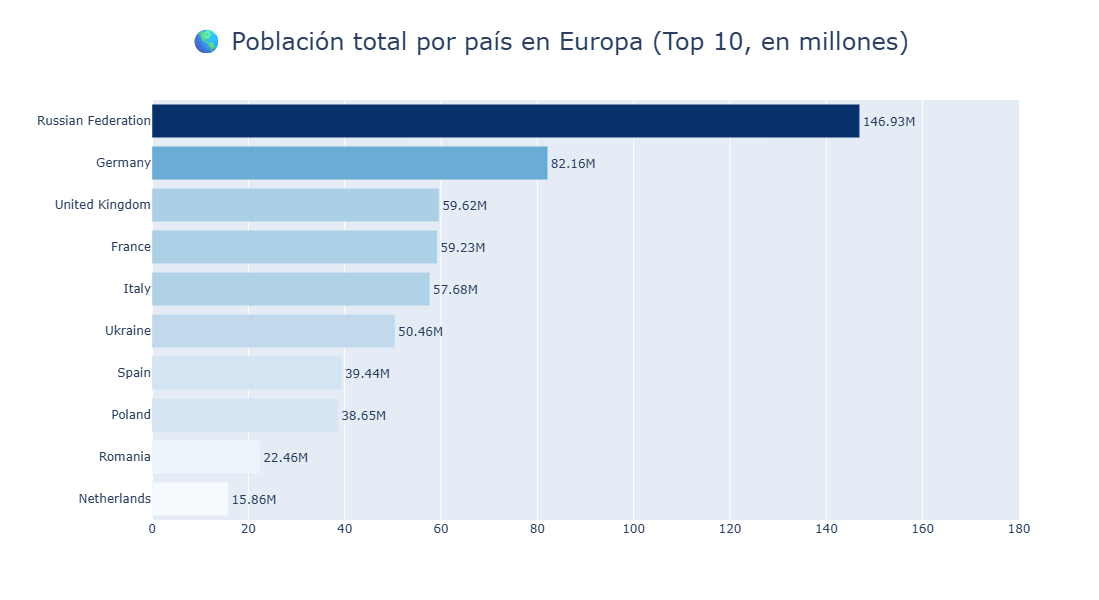

In [75]:
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df_grafico['Pais'],
    x=df_grafico['Poblacion_Millones'],
    orientation='h',
    marker=dict(
        color=df_grafico['Poblacion_Millones'],
        colorscale='Blues',
        showscale=False
    ),
    text=df_grafico['Poblacion_Millones'].apply(lambda x: f"{x:.2f}M"),
    textposition='outside'
))

fig.update_layout(
    width=1000,
    height=600,
    title={
        'text': '🌎 Población total por país en Europa (Top 10, en millones)', 
        'x': 0.5, 
        'font': {'size': 24}
    },
    xaxis_title='',
    yaxis_title='',
    yaxis=dict(autorange="reversed"),
    xaxis=dict(range=[0, 180])  
)

fig.show()

### 🟰 __CONCLUSIONES__

* El país más poblado de Europa es Rusia con + de 146 millones de personas.
* Lo sigue Alemania con 82 millones.

## 2️⃣ __Ejercicio 2:__ Escribe una consulta para mostrar los nombres y las áreas de superficie de los cinco países más grandes del mundo (en términos de área de superficie).

In [21]:
cursor.execute("""
SELECT Name as Pais, SurfaceArea as Superficie_total
FROM country
ORDER BY Superficie_total DESC
LIMIT 5
""")

In [22]:
resultados = cursor.fetchall()
columnas = ['Pais', 'Superficie_total']
df2 = pd.DataFrame(resultados, columns=columnas)

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Pais              5 non-null      object
 1   Superficie_total  5 non-null      object
dtypes: object(2)
memory usage: 212.0+ bytes


In [25]:
df2['Superficie_total']= df2['Superficie_total'].astype(int)

In [26]:
df2

,Pais,Superficie_total
0,Russian Federation,17075400
1,Antarctica,13120000
2,Canada,9970610
3,China,9572900
4,United States,9363520


In [28]:
df2.loc[:, 'Superficie_Millones'] = (df2['Superficie_total'] / 1_000_000).astype(float).round(2) # Superficie en millones de km2

In [29]:
df2

,Pais,Superficie_total,Superficie_Millones
0,Russian Federation,17075400,17.08
1,Antarctica,13120000,13.12
2,Canada,9970610,9.97
3,China,9572900,9.57
4,United States,9363520,9.36


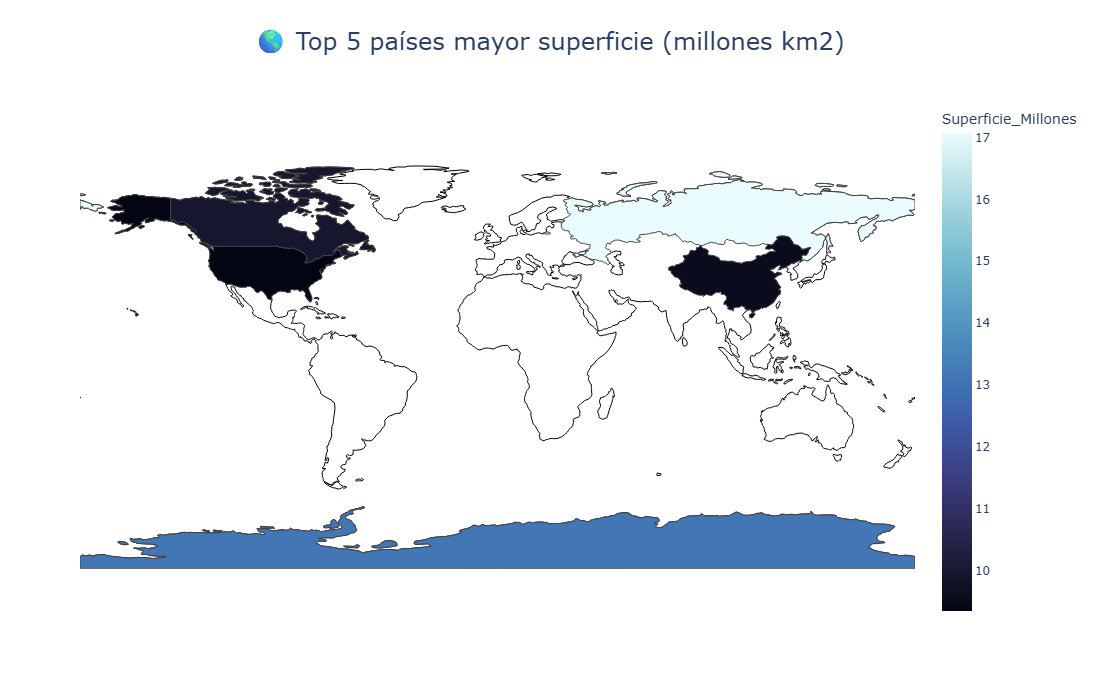

In [119]:
fig = px.choropleth(
    df2,
    locations='Pais',
    locationmode='country names',
    color='Superficie_Millones',
    color_continuous_scale='Ice',
    title='🌎 Top 5 países mayor superficie (millones km2)'
)

fig.update_geos(
    visible=True,
    showcoastlines=True,
    coastlinecolor="black",
    showland=True,
    landcolor="white",
    showocean=True,
    oceancolor="white",
    showlakes=False,
    showrivers=False,
    showframe=False
)

fig.update_layout(
    title_x=0.5,
    title_font_size=24,
    width=1000,
    height=700,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

### 🟰 __CONCLUSIONES__

* El país con mayor superficie es Rusia, con más de 17 millones de km².
* Le sigue Antártida con 13 millones de km², aunque cabe destacar que, según los datos del dataset, no se registra población en esa región.
* Canadá, China y Estados Unidos también presentan extensiones territoriales destacadas, con casi 10 millones de km² cada uno.

## 3️⃣ __Ejercicio 3:__ Escribe una consulta para calcular la población total de todos los países de cada continente y mostrar el resultado junto con el nombre del continente.

In [4]:
cursor.execute("""
SELECT continent AS Continente, 
       SUM(Population) AS Poblacion_Total
FROM country
GROUP BY continent
ORDER BY Poblacion_Total DESC;
""")

In [5]:
resultados = cursor.fetchall()
columnas = ['Continente','Poblacion_Total']
df3= pd.DataFrame(resultados, columns=columnas)

In [6]:
df3

,Continente,Poblacion_Total
0,Asia,3705025700
1,Africa,784475000
2,Europe,730074600
3,North America,482993000
4,South America,345780000
5,Oceania,30401150
6,Antarctica,0


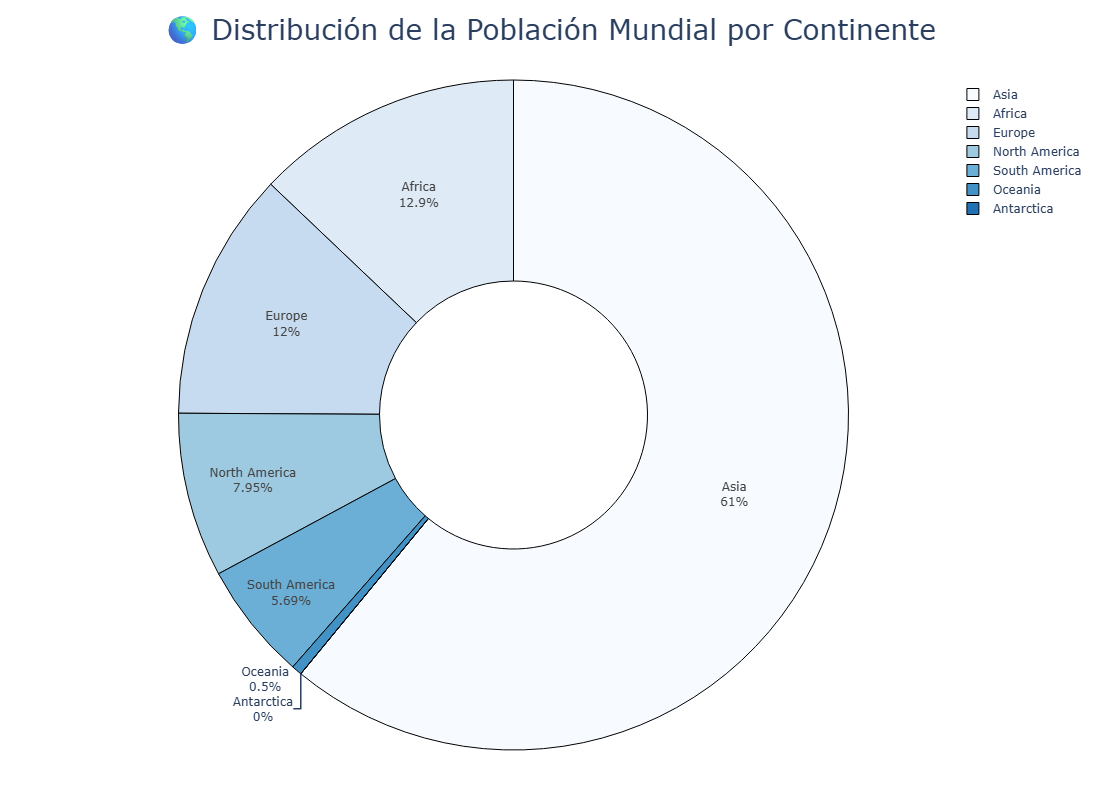

In [7]:
import plotly.express as px

Blues = px.colors.sequential.Blues

fig = px.pie(
    df3, 
    names='Continente', 
    values='Poblacion_Total',
    title='🌎 Distribución de la Población Mundial por Continente',
    color_discrete_sequence=Blues,
    hole=0.4
)

fig.update_traces(
    textposition='auto', 
    textinfo='percent+label',
    marker=dict(line=dict(color='black', width=1))
)

fig.update_layout(
    title={
        'text': '🌎 Distribución de la Población Mundial por Continente',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 28}
    },
    width=800,
    height=800,
    margin=dict(t=80, b=50, l=50, r=50),
    paper_bgcolor='white'
)

fig.show()

### 🟰 __CONCLUSIONES__

* Más del 60% de la población mundial vive en Asia.
* El segundo continente más poblado, de acuerdo a los datos disponibles es África, con un 12.9% de la población mundial, y Europa con el 12%.
* Sudamérica es el continente menos poblado (sin considerar Antártica), con el 5.69% de la población.

#### ✳️  Consulta adicional para graficar (mostrar paises)

In [15]:
cursor.execute("""
SELECT name as Pais, continent as Continente, SUM(Population) as Poblacion_Total
FROM country 
GROUP BY name, continent
ORDER BY continent ASC
""")

In [16]:
resultados = cursor.fetchall()
columnas = ['Pais','Continente','Poblacion_Total']
df3a= pd.DataFrame(resultados, columns=columnas)

In [17]:
df3a

,Pais,Continente,Poblacion_Total
0,Afghanistan,Asia,22720000
1,United Arab Emirates,Asia,2441000
2,Armenia,Asia,3520000
3,Azerbaijan,Asia,7734000
4,Bangladesh,Asia,129155000
...,...,...,...
234,Peru,South America,25662000
235,Paraguay,South America,5496000
236,Suriname,South America,417000
237,Uruguay,South America,3337000


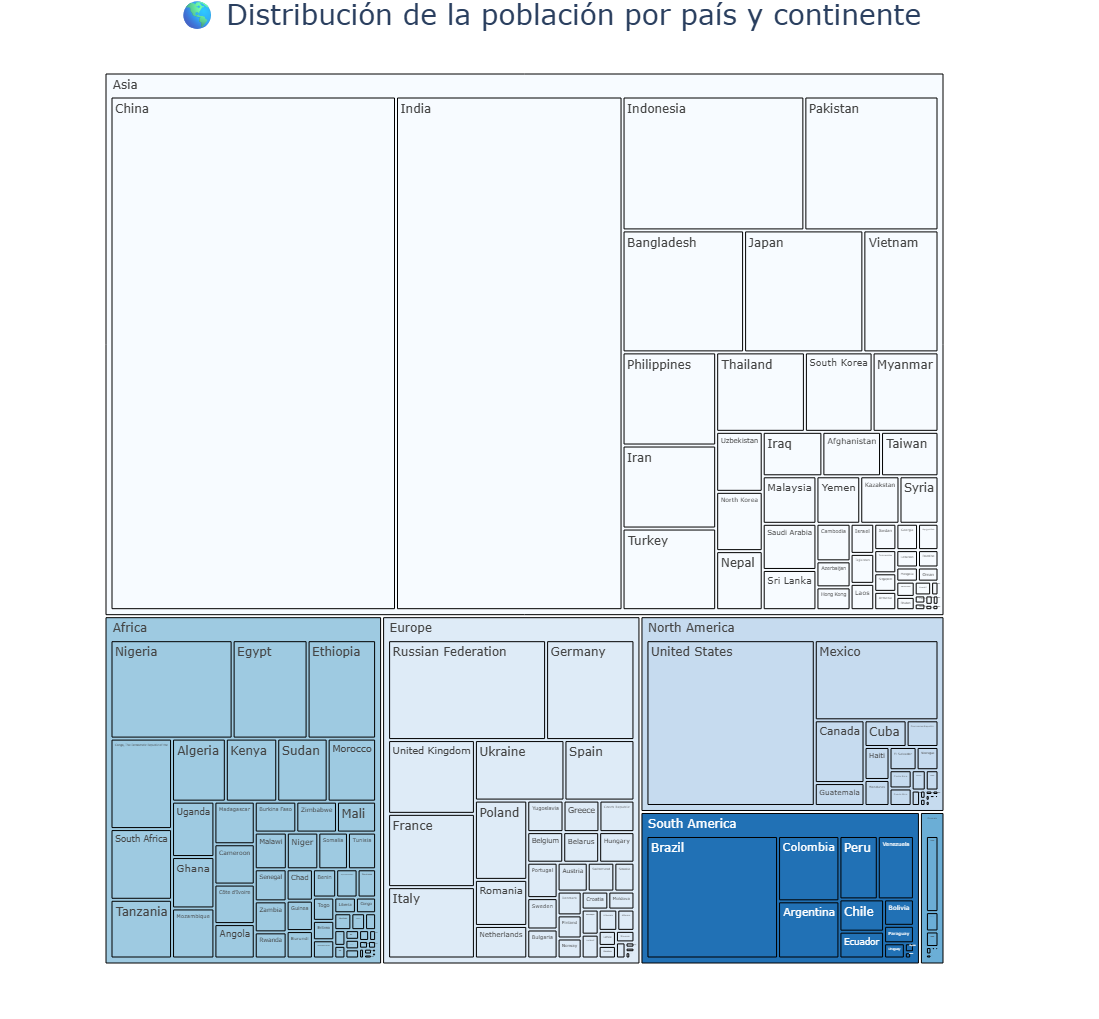

In [21]:
blue_colors = px.colors.sequential.Blues

continentes = df3a['Continente'].unique()
paleta_continentes_blue = {cont: blue_colors[i % len(blue_colors)] for i, cont in enumerate(continentes)}

fig = px.treemap(
    df3a,
    path=['Continente', 'Pais'],
    values='Poblacion_Total',
    color='Continente',
    color_discrete_map=paleta_continentes_blue,
    title='🌎 Distribución de la población por país y continente',
)

fig.update_traces(
    marker=dict(line=dict(color='black', width=1)) ,
    hovertemplate="<b>País:</b> %{label}<br><b>Población:</b> %{value:,}<br>"
)
fig.update_layout(
    title={
        'text': '🌎 Distribución de la población por país y continente',
        'x': 0.5,
        'font': {'size': 28}
    },
    autosize=True,
    width=1100,  
    height=1000,  
    margin=dict(t=50, b=50, l=100, r=150)
)

fig.show()

### 🟰 __CONCLUSIONES__

* Este gráfico tipo treemap nos permite visualizar rápidamente cuáles son los continentes más poblados y los menos poblados.
* Dentro de cada continente, también podemos identificar cuáles son los países con mayor población.
* La población de China o India supera a la población total de África o Europa.
* Brasil es el país más poblado de Sudamérica, con 170.115.000 habitantes.

## 4️⃣ __Ejercicio 4:__ Escribe una consulta para mostrar el nombre de las ciudades y la población de todos los países de Europa, ordenados por población de la ciudad de manera descendente.

In [150]:
cursor.execute("""
SELECT 
ci.name as Ciudad,
co.name as Pais,
ci.Population as Poblacion_Total
FROM city ci
LEFT JOIN country co ON ci.CountryCode = co.Code
WHERE co.Continent = 'Europe'
ORDER by Poblacion_Total DESC
""")

In [151]:
resultados = cursor.fetchall()
columnas = ['Ciudad','Pais','Poblacion_Total']
df4= pd.DataFrame(resultados, columns=columnas)

In [152]:
df4

,Ciudad,Pais,Poblacion_Total
0,Moscow,Russian Federation,8389200
1,London,United Kingdom,7285000
2,St Petersburg,Russian Federation,4694000
3,Berlin,Germany,3386667
4,Madrid,Spain,2879052
...,...,...,...
836,Serravalle,San Marino,4802
837,San Marino,San Marino,2294
838,Longyearbyen,Svalbard and Jan Mayen,1438
839,Monaco-Ville,Monaco,1234


In [153]:
df4B = df4.head(30)
df4B

,Ciudad,Pais,Poblacion_Total
0,Moscow,Russian Federation,8389200
1,London,United Kingdom,7285000
2,St Petersburg,Russian Federation,4694000
3,Berlin,Germany,3386667
4,Madrid,Spain,2879052
5,Roma,Italy,2643581
6,Kyiv,Ukraine,2624000
7,Paris,France,2125246
8,Bucuresti,Romania,2016131
9,Budapest,Hungary,1811552


In [154]:
geolocator = Nominatim(user_agent="my_unique_app_name_12345") # Utilizamos geolocator para obtener las coordenadas en el mapa, de las ciudades

In [167]:
# Esta función recibe una ciudad y un país, intenta obtener su latitud y longitud usando el geolocalizador Nominatim, y devuelve esas coordenadas como una serie de pandas. Si falla, devuelve None para ambas.
if 'Latitude' not in df4B.columns:
    df4B['Latitude'] = None
if 'Longitude' not in df4B.columns:
    df4B['Longitude'] = None

def get_coordinates(city, country):
    try:
        location = geolocator.geocode(f"{city}, {country}", timeout=10)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Error with {city}, {country}: {e}")
    return None, None

for idx, row in df4B.iterrows():
    lat, lon = get_coordinates(row['Ciudad'], row['Pais'])
    df4B.at[idx, 'Latitude'] = lat
    df4B.at[idx, 'Longitude'] = lon
    time.sleep(1)  

print(df4B[['Ciudad', 'Pais', 'Latitude', 'Longitude']])

              Ciudad                Pais   Latitude  Longitude
0             Moscow  Russian Federation  55.625578  37.606392
1             London      United Kingdom  51.489334  -0.144055
2      St Petersburg  Russian Federation  59.938732  30.316229
3             Berlin             Germany  52.510885  13.398937
4             Madrid               Spain  40.416705  -3.703582
5               Roma               Italy  41.893320  12.482932
6               Kyiv             Ukraine  50.450034  30.524136
7              Paris              France  48.853495   2.348391
8          Bucuresti             Romania  44.436141  26.102720
9           Budapest             Hungary  47.497879  19.040238
10           Hamburg             Germany  53.550341  10.000654
11             Minsk             Belarus  53.902472  27.561823
12          Warszawa              Poland  52.233717  21.071432
13              Wien             Austria  48.208354  16.372504
14         Barcelona               Spain  41.382580   2

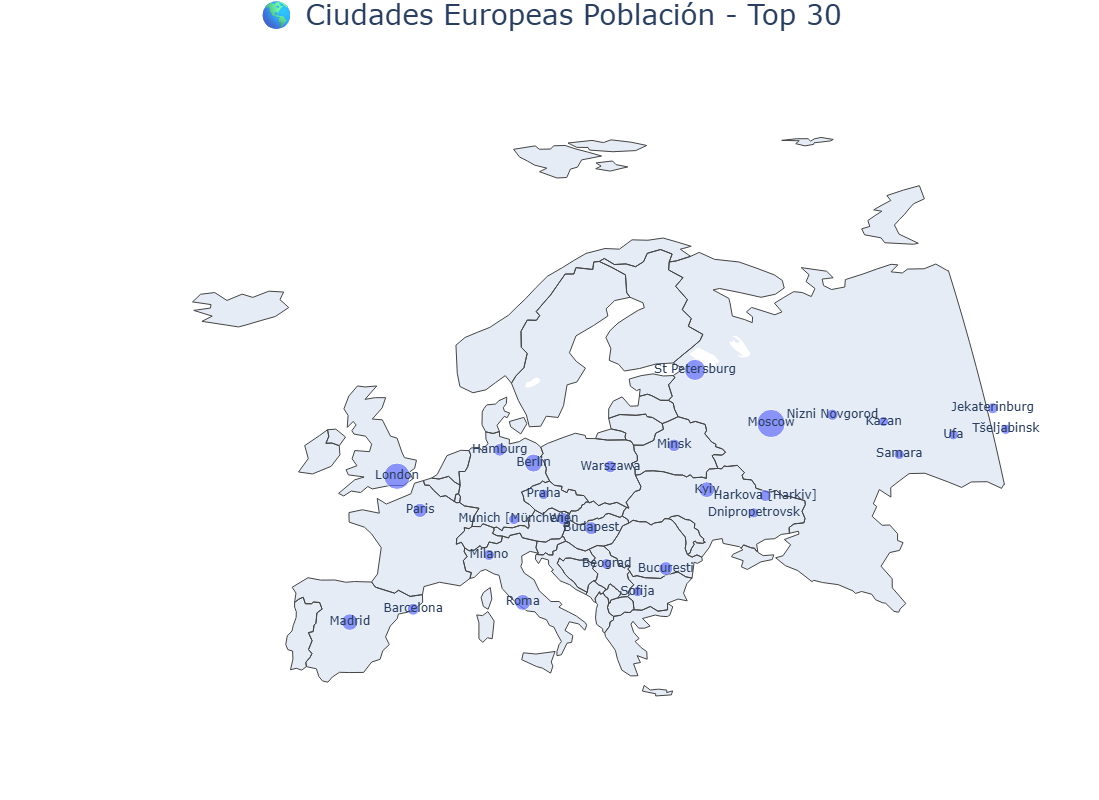

In [168]:
fig = px.scatter_geo(
    df4B,
    lat='Latitude',
    lon='Longitude',
    text='Ciudad',
    size='Poblacion_Total',
    hover_name='Ciudad',
    projection='natural earth',
    title='🌎 Ciudades Europeas por Población - Top 30',
    scope='europe',
    custom_data=['Ciudad', 'Pais', 'Poblacion_Total']
)
fig.update_traces(
    hovertemplate=
        "<b>%{customdata[0]}</b><br>" +
        "País: %{customdata[1]}<br>" +
        "Población: %{customdata[2]:,}<br>" +
        "<extra></extra>"
)
fig.update_layout(
    title={
        'text': '🌎 Ciudades Europeas Población - Top 30',
        'x': 0.5,
        'font': {'size': 28}  # Título más grande
    },
    width=1000,
    height=800,
    margin=dict(t=50, b=50, l=50, r=50)
)
fig.show()

###  🟰 CONCLUSIONES
* Moscú (Rusia) es la ciudad más poblada de la lista, con más de 8,3 millones de habitantes, seguida por Londres (Reino Unido) con 7,28 millones y San Petersburgo (Rusia) con 4,69 millones.
* Rusia domina ampliamente el ranking, con 9 ciudades entre las 30 más pobladas de Europa, lo que refleja su gran extensión territorial e importancia demográfica.
* Alemania, Ucrania e Italia también presentan múltiples ciudades entre las más pobladas, lo que indica una distribución poblacional significativa en varias regiones.

## 5️⃣ __Ejercicio 5:__ Actualiza la población de China (código de país 'CHN') a 1500000000 (1.5 mil millones).

In [123]:
cursor.execute("""
UPDATE country 
SET country.population = 1500000000
WHERE country.code = 'CHN'
""")

In [11]:
cursor.execute("""
SELECT code as Código , name as Pais, Population as Poblacion_Total
FROM country
WHERE code = 'CHN'
""")

In [12]:
resultados = cursor.fetchall()
columnas = ['Código','Pais','Poblacion_Total']
df5= pd.DataFrame(resultados, columns=columnas)

In [13]:
df5

,Código,Pais,Poblacion_Total
0,CHN,China,1500000000


## 6️⃣ __Ejercicio 6:__ Consulta los idiomas oficiales en Sudamérica y gráfica cuántos países comparten cada idioma oficial.

In [3]:
cursor.execute("""SELECT cl.Language AS Idioma, COUNT(DISTINCT c.Name) AS Total_Paises
FROM countrylanguage AS cl
LEFT JOIN country AS c ON cl.CountryCode = c.Code
WHERE c.Continent = 'South America' AND cl.IsOfficial = 'T'
GROUP BY cl.Language
ORDER BY Total_Paises DESC;
""")

In [4]:
resultados = cursor.fetchall()
columnas = ['Idioma','Total_Paises']
df6= pd.DataFrame(resultados, columns=columnas)

In [5]:
df6

,Idioma,Total_Paises
0,Spanish,9
1,Aimará,2
2,Ketšua,2
3,English,1
4,Guaraní,1
5,Portuguese,1


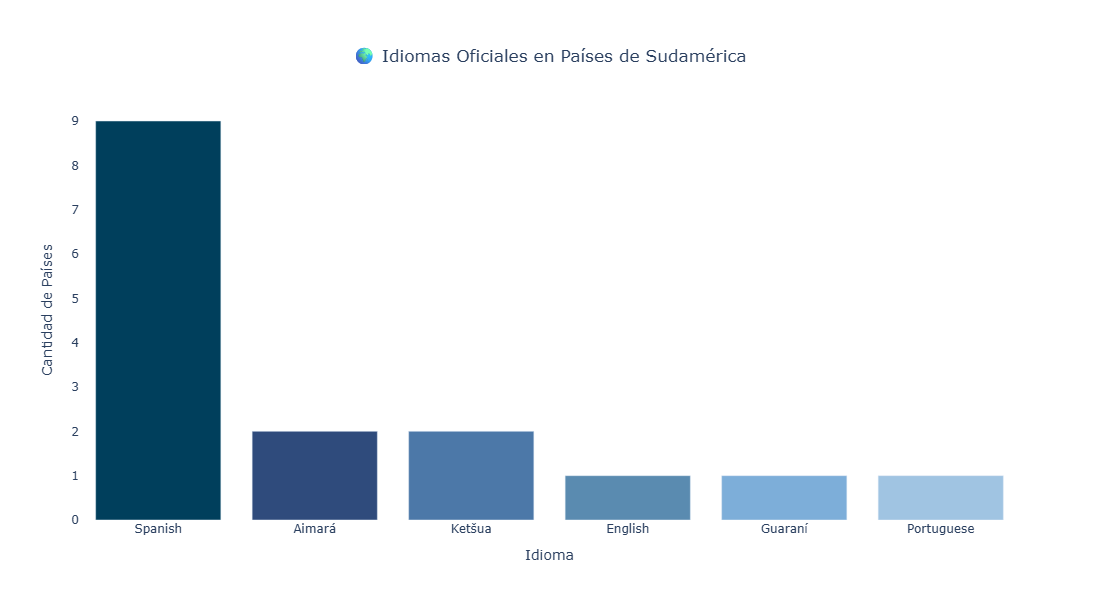

In [16]:
df6_sorted = df6.sort_values("Total_Paises", ascending=False).reset_index(drop=True)
blues = ['#003f5c', '#2f4b7c', '#4c78a8', '#5a8bb0', '#7daed9', '#a0c4e2', '#c1d9ee']  
color_map = {idioma: blues[i] for i, idioma in enumerate(df6_sorted["Idioma"])}  
fig = px.bar(
    df6_sorted,
    x="Idioma",
    y="Total_Paises",
    color="Idioma",
    color_discrete_map=color_map,
    title="🌍 Idiomas Oficiales en Países de Sudamérica"
)

fig.update_layout(
    xaxis_title="Idioma",
    yaxis_title="Cantidad de Países",
    plot_bgcolor="white",
    height=600,
    title={
        'text': "🌍 Idiomas Oficiales en Países de Sudamérica",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    showlegend=False
)

fig.show()

#### ✳️  Consulta adicional- Para conocer qué países hablan cada idioma

In [20]:
cursor.execute("""SELECT cl.Language AS Idioma, c.Name AS Pais
FROM countrylanguage AS cl
LEFT JOIN country AS c ON cl.CountryCode = c.Code
WHERE c.Continent = 'South America' AND cl.IsOfficial = 'T'
ORDER BY Idioma DESC;
""")

In [21]:
resultados = cursor.fetchall()
columnas = ['Idioma','Pais']
df6b= pd.DataFrame(resultados, columns=columnas)

In [34]:
df6b

,Idioma,Pais
0,Spanish,Argentina
1,Spanish,Bolivia
2,Spanish,Chile
3,Spanish,Colombia
4,Spanish,Ecuador
5,Spanish,Peru
6,Spanish,Paraguay
7,Spanish,Uruguay
8,Spanish,Venezuela
9,Portuguese,Brazil


### 🟰 CONCLUSIONES
* El español es el idioma más difundido, hablado en 9 países, lo que resalta su fuerte presencia en América Latina.
* Aimará y quechua (ketšua), ambos idiomas originarios de pueblos indígenas andinos, se hablan en 2 países cada uno (Bolivia y Perú), reflejando su importancia cultural y geográfica.
* Inglés, guaraní y portugués aparecen en un solo país cada uno: inglés en las Islas Malvinas, guaraní en Paraguay, y portugués en Brasil.

## 7️⃣ __Ejercicio 7:__ Obtén todos los países con esperanza de vida > 75 años y crea un histograma de su distribución.

In [36]:
cursor.execute("""SELECT Name AS Pais, LifeExpectancy AS Esperanza_de_Vida
FROM Country
WHERE LifeExpectancy > 75
""")

In [37]:
resultados = cursor.fetchall()
columnas = ['Pais','Esperanza_de_Vida']
df7= pd.DataFrame(resultados, columns=columnas)

In [38]:
df7

,Pais,Esperanza_de_Vida
0,Aruba,78.4
1,Anguilla,76.1
2,Andorra,83.5
3,Argentina,75.1
4,American Samoa,75.1
...,...,...
57,Taiwan,76.4
58,Uruguay,75.2
59,United States,77.1
60,"Virgin Islands, British",75.4


In [52]:
df7.sort_values('Esperanza_de_Vida', ascending = False)

,Pais,Esperanza_de_Vida
2,Andorra,83.5
40,Macao,81.6
54,San Marino,81.1
35,Japan,80.7
52,Singapore,80.1
...,...,...
60,"Virgin Islands, British",75.4
33,Jamaica,75.2
58,Uruguay,75.2
4,American Samoa,75.1


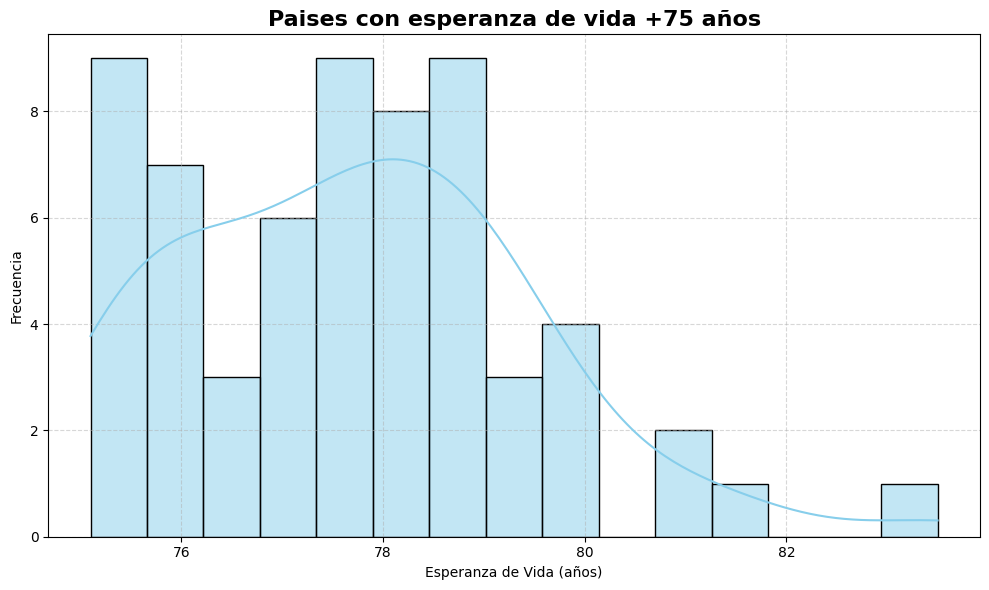

In [191]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df7, x='Esperanza_de_Vida', bins=15, kde=True, color='skyblue')

plt.title('Paises con esperanza de vida +75 años', fontsize=16, weight='bold')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### ✳️  Cálculo de paises por continente con esperanza de vida + 75 años

In [41]:
# Unimos la consulta con el dfcountry (obtenido en la exploración de datos)
df7b = df7.merge(
    dfcountry[['Name', 'Continent']],
    left_on='Pais',
    right_on='Name',
    how='left'
).drop(columns='Name')
df7b

,Pais,Esperanza_de_Vida,Continent
0,Aruba,78.4,North America
1,Anguilla,76.1,North America
2,Andorra,83.5,Europe
3,Argentina,75.1,South America
4,American Samoa,75.1,Oceania
...,...,...,...
57,Taiwan,76.4,Asia
58,Uruguay,75.2,South America
59,United States,77.1,North America
60,"Virgin Islands, British",75.4,North America


In [50]:
# Calculamos cuantos paises de cada continente tienen esperanza vida +75 años
df7b_grouped = df7b.groupby('Continent')['Pais'].count().reset_index().sort_values('Pais', ascending = False)
df7b_grouped

,Continent,Pais
2,Europe,25
3,North America,17
1,Asia,9
4,Oceania,5
5,South America,4
0,Africa,2


### 🟰 CONCLUSIONES
* Solo 1 país (Andorra) supera los 82 años de esperanza de vida, y son pocos los que superan los 80.
* Europa (25 países) lidera el sector, reflejando altos niveles de desarrollo y buenos sistemas de salud.
* Norteamérica (17) y Asia (9) muestran una presencia moderada, con disparidades internas.
* Oceanía (5) y Sudamérica (4) tienen pocos países con alta esperanza de vida.
* África (2) queda rezagada, evidenciando desafíos en salud y condiciones de vida.

## 8️⃣ __Ejercicio 8:__ Calcula la densidad poblacional de todos los países y muestra un gráfico de dispersión entre superficie y población con el color como función del continente.

In [54]:
cursor.execute("""SELECT 
  Name AS Pais,
  Continent AS Continente,
  SurfaceArea AS Superficie_km2,
  Population AS Poblacion,
  ROUND(Population / SurfaceArea) AS Densidad_Poblacional
FROM 
  country
WHERE SurfaceArea > 0
ORDER BY Densidad_Poblacional DESC;
""")

In [55]:
resultados = cursor.fetchall()
columnas = ['Pais','Continente','Superficie_km2','Poblacion','Densidad_Poblacional']
df8= pd.DataFrame(resultados, columns=columnas)

In [57]:
df8.head(25)

,Pais,Continente,Superficie_km2,Poblacion,Densidad_Poblacional
0,Macao,Asia,18.00,473000,26278
1,Monaco,Europe,1.50,34000,22667
2,Hong Kong,Asia,1075.00,6782000,6309
3,Singapore,Asia,618.00,3567000,5772
4,Gibraltar,Europe,6.00,25000,4167
5,Holy See (Vatican City State),Europe,0.40,1000,2500
6,Bermuda,North America,53.00,65000,1226
7,Malta,Europe,316.00,380200,1203
8,Maldives,Asia,298.00,286000,960
9,Bangladesh,Asia,143998.00,129155000,897


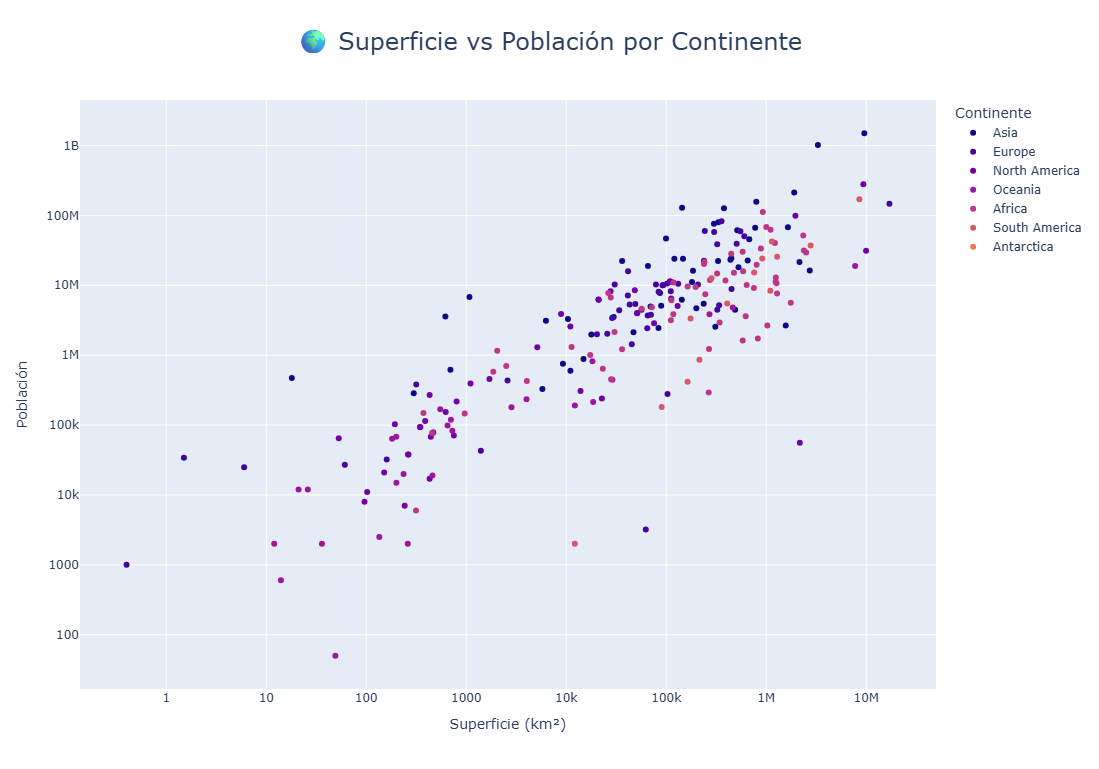

In [135]:
fig = px.scatter(
    df8,
    x='Superficie_km2',
    y='Poblacion',
    color='Continente',  
    size_max=40,
    title='🌍 Superficie vs Población por Continente',
    labels={
        'Superficie_km2': 'Superficie (km²)',
        'Poblacion': 'Población'
    },
    color_discrete_sequence=px.colors.sequential.Plasma,  
    width=1100,
    height=750
)

# Centrar el título y ajustar el estilo
fig.update_layout(
    title={
        'text': '🌍 Superficie vs Población por Continente',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24}
    },
    legend_title_text='Continente',
    xaxis_type='log', 
    yaxis_type='log'
)

fig.show()

#### 🟰 CONCLUSIONES

* Macao y Mónaco lideran con densidades extremas, superando los 22.000 hab/km².
* Predominan territorios pequeños y altamente urbanizados de Asia y Europa.
* Islas y microestados (Malta, Nauru, Tuvalu) también presentan altas densidades por su superficie reducida.
* Países como Bangladesh y Corea del Sur combinan gran población con territorio limitado, resultando en alta densidad.

## 9️⃣ __Ejercicio 9:__ Visualiza las ciudades con más de 5 millones de habitantes en un gráfico horizontal de barras.

In [58]:
cursor.execute("""SELECT Name as Ciudad,
Population as Poblacion
FROM city
WHERE Population > 5000000
ORDER BY Population DESC
""")

In [59]:
resultados = cursor.fetchall()
columnas = ['Ciudad','Poblacion']
df9= pd.DataFrame(resultados, columns=columnas)

In [60]:
df9

,Ciudad,Poblacion
0,Mumbai (Bombay),10500000
1,Seoul,9981619
2,São Paulo,9968485
3,Shanghai,9696300
4,Jakarta,9604900
5,Karachi,9269265
6,Istanbul,8787958
7,Ciudad de México,8591309
8,Moscow,8389200
9,New York,8008278


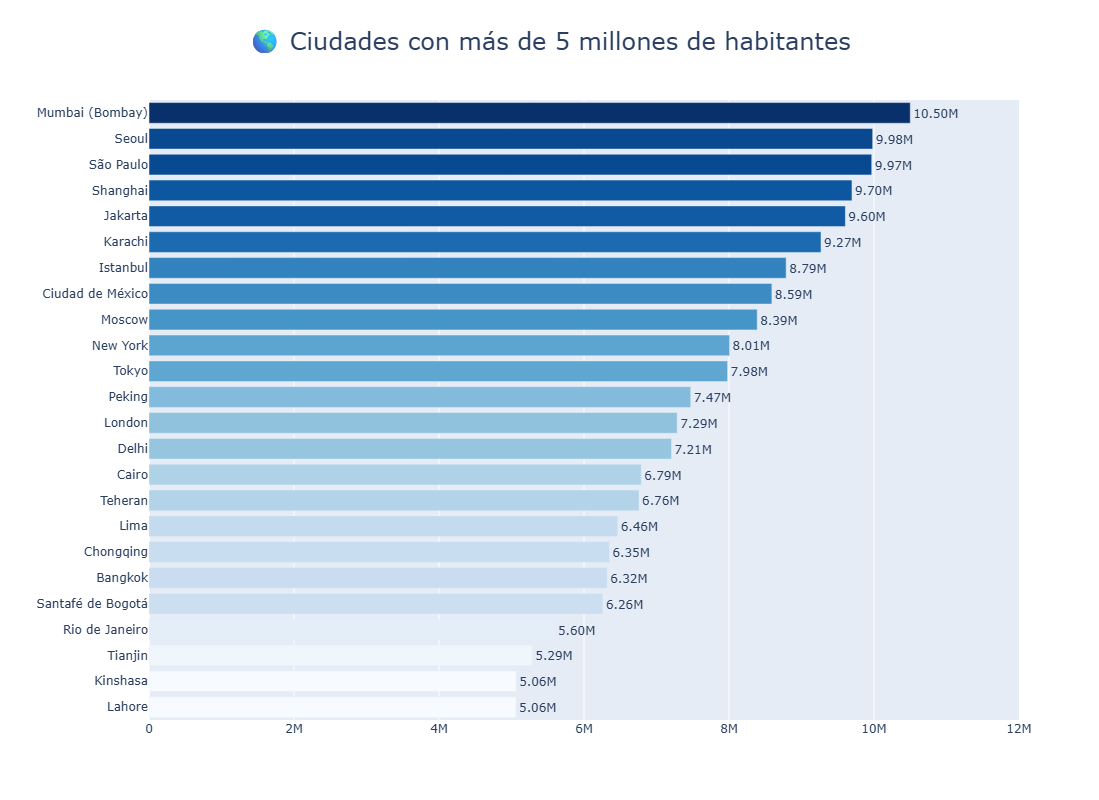

In [293]:
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df9['Ciudad'],
    x=df9['Poblacion'],
    orientation='h',
    marker=dict(
        color=df9['Poblacion'],
        colorscale='Blues',
        showscale=False
    ),
    text=(df9['Poblacion'] / 1_000_000).apply(lambda x: f"{x:.2f}M"),
    textposition='outside'
))

fig.update_layout(
     xaxis=dict(
        range=[0, 12_000_000]
    ),
    width=1000,
    height=800,
    title={
        'text': '🌎 Ciudades con más de 5 millones de habitantes', 
        'x': 0.5, 
        'font': {'size': 24}
    },
    xaxis_title='',
    yaxis_title='',
    yaxis=dict(autorange="reversed"),
    
)
fig.show()

#### 🟰 CONCLUSIONES

* Solo 23 ciudades en el mundo superan los 5 millones de habitantes.
* Las ciudades más pobladas están en Asia, destacándose Bombay (India, 10.50 M) y Seúl (Corea del Sur, 9.98 M).
* La tercera ciudad más poblada es San Pablo (Brasil), liderando en América Latina.

## 1️⃣0️⃣ __Ejercicio 10:__ Gráfica cuántos idiomas se hablan por continente usando un gráfico de pastel.

In [30]:
cursor.execute("""SELECT Continent as Continente,
COUNT(Language) as Total_idiomas
FROM countrylanguage cl
LEFT JOIN country AS c ON cl.CountryCode = c.Code
GROUP BY Continent
ORDER BY Total_idiomas DESC
""")

In [31]:
resultados = cursor.fetchall()
columnas = ['Continente','Total_Idiomas']
df10= pd.DataFrame(resultados, columns=columnas)

In [32]:
df10

,Continente,Total_Idiomas
0,Africa,310
1,Asia,239
2,Europe,202
3,North America,109
4,Oceania,82
5,South America,42


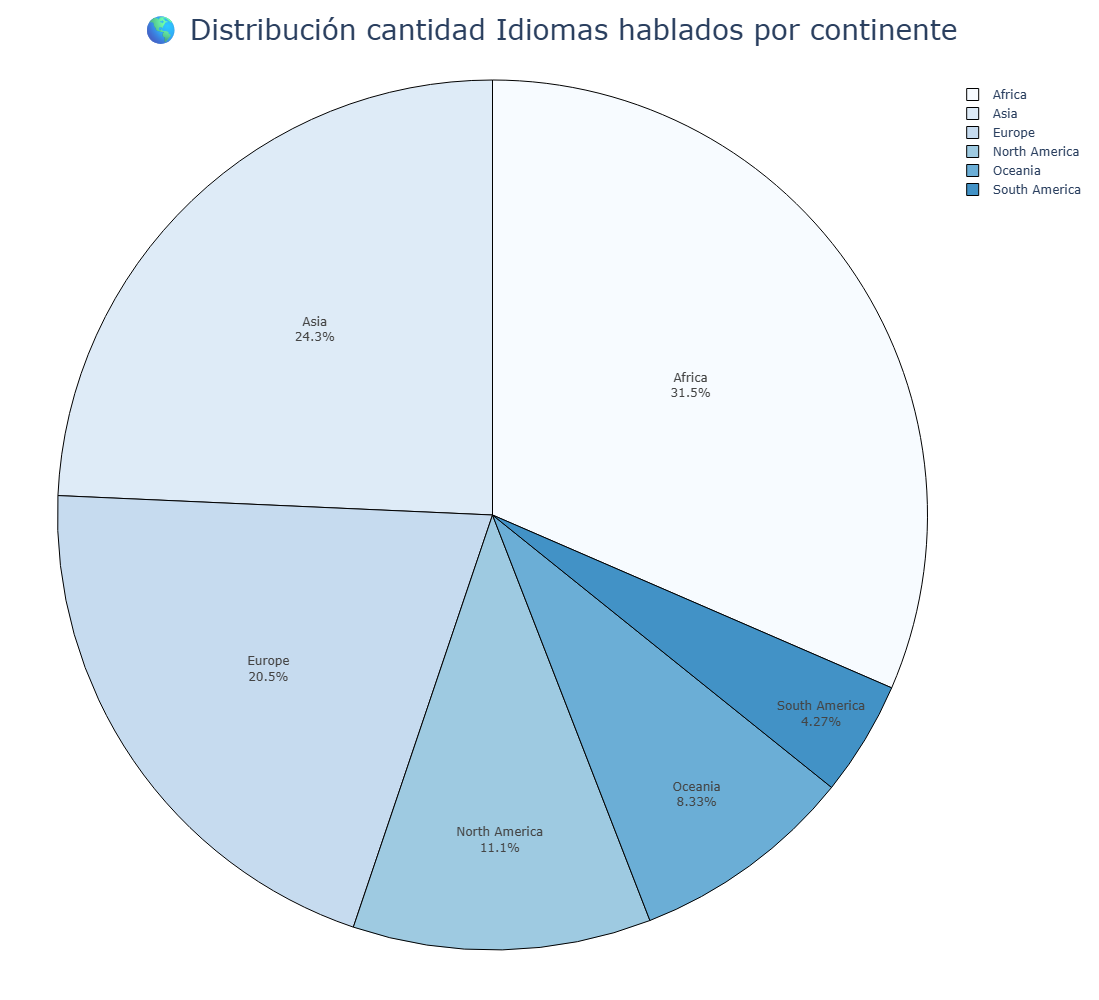

In [35]:
blue_palette = px.colors.sequential.Blues

fig = px.pie(
    df10, 
    names='Continente', 
    values='Total_Idiomas',
    title='🌎 Distribución de Idiomas por continente',
    color_discrete_sequence=blue_palette,
)

fig.update_traces(
    textposition='inside', 
    textinfo='percent+label',
    marker=dict(line=dict(color='black', width=1))
)

fig.update_layout(
    title={
        'text': '🌎 Distribución cantidad Idiomas hablados por continente',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 28}
    },
    width=1000,
    height=1000,
    margin=dict(t=80, b=50, l=50, r=50),
    paper_bgcolor='white'
)

fig.show()

#### 🟰 CONCLUSIONES

* África concentra la mayor diversidad lingüística, con 310 idiomas oficiales y no oficiales.
* Asia y Europa también presentan gran diversidad, con más de 200 lenguas diferentes cada uno.
* Sudamérica es el continente con menor diversidad lingüística, con solo 42 idiomas reconocidos.

In [36]:
#Cierre conexión Base de Datos
cursor.close()
conexion.close()
print("Conexión cerrada")

Conexión cerrada
